In [23]:
import sys
root_data='/data/nak168/spatial_temporal/stream_img/data/fpe-westbrook/'
root='/data/nak168/spatial_temporal/stream_img/CGAN'
sys.path.append(root)

In [25]:
%env TORCH_EXTENSIONS_DIR="/data/nak168/.cache/torch_extensions"

env: TORCH_EXTENSIONS_DIR="/data/nak168/.cache/torch_extensions"


In [3]:
# !pip install Ninja
# !wget https://anaconda.org/conda-forge/ninja/1.11.1/download/linux-64/ninja-1.11.1-h924138e_0.conda
# conda install ninja-1.11.1-h924138e_0.conda

In [4]:
import cv2
import numpy as np
import glob
import xml.etree.ElementTree as ET
import os
import sys
import math
from collections import defaultdict

# from tables import Column
from PIL import Image
import json
import pandas as pd
import datetime
from datetime import datetime, timedelta, timezone
import requests
import shutil
import time
from skimage.metrics import mean_squared_error, structural_similarity, normalized_root_mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import h5py

import torch
import torch.utils.data
import torch.utils.data as Data
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

In [5]:
# one folder

# def download_image(url, file_path, file_name=""):
#   # print("downloading "+url)
#   full_path = file_path + file_name
#   res = requests.get(url, stream = True)
#   if res.status_code == 200:
#     with open(full_path,'wb') as f:
#         shutil.copyfileobj(res.raw, f)
#     # print('Image sucessfully Downloaded: ',file_name)
#   else:
#     print('Image Couldn\'t be retrieved '+ res.status_code)

def download_image(url, file_path, file_name=""):
    # download from image url and import it as a numpy array
    full_path = file_path + file_name
    res = requests.get(url, stream=True) # get full image
    if res.status_code == 200:
      img=res.raw
      img = Image.open(img)
      img = img.resize((360,360))
      # img = ImageOps.grayscale(img) # grayscale
      img = img.tobytes() # convert to bytes
      img = bytearray(img) # create byte array
      img = np.asarray(img, dtype="uint8") # 360x360 array
      img = img.reshape(360, 360, 3)
      np.save(full_path,img)

      # with open(full_path, 'rb') as f:
      #   img = np.load(full_path)
      #   img=img.astype('float32') / 255
      # fig,ax = plt.subplots(1)
      # ax.imshow(img)

    else:
      print('Image Couldn\'t be retrieved '+ res.status_code)
    return img

class ImageNetVidDataset(torch.utils.data.Dataset):

  def __init__(self, path, fol, phase="train", len_seq=1, transform=None, mask_frac=0):

    self.len_seq=len_seq
    self.transform = transform

    cur_path = path

    # load
    images, temps, dates=self.load_data(cur_path, fol)

    # sort
    images, temps, dates=self.sort_data(images, temps, dates)

    # normalize
    self.normalizer = StandardScaler()
    temps = self.normalizer.fit_transform(temps)

    self.timetransformer=MinMaxScaler()
    dates =self.timetransformer.fit_transform(dates)
    self.timestamps=dates
    # temps=np.log(temps+1)

    # # mask
    # random_indices = np.random.choice(temps.shape[0], size=int(temps.shape[0] * mask_frac), replace=False)
    # temps[random_indices,:]=[None]

    images, temps, dates=self.generate_many2many_data2(self.len_seq, images, temps, dates)
    # split to train, val, test
    self.images,self.labels,self.dates=self.data_split(images,temps,dates,phase,mask_frac)
    # self.images,self.labels,self.dates=self.generate_many2many_data_split(self.len_seq, images, temps, dates, phase)

    # # download images (do just for first time)
    # if not os.path.exists(cur_path+"/"+fol+"/images/"):
    #   os.mkdir(cur_path+"/"+fol+"/images/")
    # delay=0.001
    # for i, (id,url) in enumerate(zip(self.imgs.image_id,self.imgs.url)):
    #   count=0
    #   while True:
    #       try:
    #         download_image(url,cur_path+fol+"/images/"+ str(id)+".jpg")
    #         self.imgs.ix[i,"image_path"]=cur_path+fol+"/images/"+ str(id)+".jpg"
    # #         download_image2(url,cur_path+fol+"/images/"+ str(id)+".npy")
    # #         self.imgs.loc[:,"image_path"].iloc[i]=cur_path+fol+"/images/"+ str(id)+".npy"
    #         time.sleep(delay)
    #         break
    #       except Exception as e:
    #         # raise e
    #         print("error: ", e, "url: ",url)
    #         if count>5:
    #             break
    #         count+=1
    #         time.sleep(10*count)

  def half_up_minute(self, x):
    delta = timedelta(minutes=15)
    ref_time = datetime(1970,1,1, tzinfo=x.tzinfo)
    return ref_time + round((x - ref_time) / delta) * delta

  def _loadimage(self, path, url):
    # # load ".jpg" files
    # with open(path, 'rb') as f:
    #   img = Image.open(f)
    #   return img.convert('RGB')
    try:
      with open(path, 'rb') as f:
        img = np.load(path,allow_pickle=True)
        return img
    except:
      img = download_image(url,path)
      with open(path, 'rb') as f:
        img = np.load(path,allow_pickle=True)
        return img

  def denormalize(self, pred):
    return self.normalizer.inverse_transform(pred)

  def load_data_from_h5(h5Path):
      f = h5py.File(h5Path, 'r')
      images = f['image']
      temps = f['temps']
      depths = f['depths']
      dates = f['dates']

      return images, temps, depths, dates

  def load_data(self, cur_path, fol):
      imgfile=pd.read_csv(cur_path + fol + '/images.csv',dtype={'station_name':str,'station_id':int,'image_id':int,'timestamp':str,'filename':str,'url':str}, parse_dates=['timestamp'])
      valuesfile = pd.read_csv(cur_path + fol + '/values.csv',dtype={'station_name':str,'station_id':int,'dataset_id':int,'series_id':int,'variable_id':str,'timestamp':str,'value':float}, parse_dates=['timestamp'])
      stationfile = pd.read_csv(cur_path + fol + '/station.csv')

      # preprocessing time
      imgfile['timestamp'] = imgfile['timestamp'].map(self.half_up_minute)
      valuesfile['timestamp'] = valuesfile['timestamp'].map(self.half_up_minute)

      data = imgfile.merge(valuesfile,on=["station_id","timestamp"])

      min_time=min(imgfile['timestamp'])
      max_time=max(imgfile['timestamp'])
      self.num_days=(max_time-min_time).days
      times=data['timestamp'].apply(datetime.timestamp)
#       times=data['timestamp'].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

      images=[]
      temps=[]
      dates=[]
      tmp=[]
      depths=[]
      for i, (id,url,v,t) in enumerate(zip(data.image_id,data.url,data.value,times)):
        # images.append(np.array(Image.fromarray(self._loadimage(cur_path+fol+"/images/"+ str(id)+".npy",url)).convert('L')))
        # img_cur=self._loadimage(cur_path+fol+"/images/"+ str(id)+".npy",url)
        # if self.transform is not None:
        #   img_cur=self.transform(img_cur)

        images.append([cur_path+fol+"/images/"+ str(id)+".npy",url,id])
        temps.append([v])
        dates.append([t])

      # # import h5py
      #   tmp.append(np.array(Image.fromarray(self._loadimage(cur_path+fol+"/images/"+ str(id)+".npy",url)).convert('L')))
      #   depths.append([0])

      # with h5py.File('/content/drive/My Drive/spatial_temporal/stream_img/fpe-westbrook/h5_2019.h5','w') as f:
      #   f['image'] = np.array(tmp)
      #   f['dates'] = np.array(dates)
      #   f['temps'] = np.array(temps)
      #   f['depths'] = np.array(depths)

      dates=np.array(dates)
      images=np.array(images)
      temps=np.array(temps)

      return images, temps, dates


  def sort_data(self, images, temps, dates):
      index = np.argsort(dates, axis=0)
      index = index.reshape(index.shape[0],)
      return images[index], temps[index], dates[index]

  def generate_many2many_data2(self, time_step, images, temps, dates):
      img_len = images.shape[0]
      train_x = []
      train_y = []
      train_d = []
      for i in range(0, img_len - time_step + 1, time_step):   # non-overlap
          train_x.append(images[i : i + time_step][:])
          train_y.append(temps[i : i + time_step][:])
          # train_y.append(np.concatenate((temps[i : i + time_step][:], depths[i : i + time_step][:]), axis=1))
          train_d.append(dates[i : i + time_step][:])
      train_x = np.array(train_x)
      train_y = np.array(train_y)
      train_d = np.array(train_d)

      return train_x, train_y, train_d

  def generate_many2many_data_split(self, time_step, images, temps, dates, phase):
      img_len = images.shape[0]
      train_x = []
      train_y = []
      train_d = []
      if phase=="train":
        for i in range(0, img_len - time_step + 1, 2*time_step):   # non-overlap
            train_x.append(images[i : i + time_step][:])
            train_y.append(temps[i : i + time_step][:])
            train_d.append(dates[i : i + time_step][:])
        train_x = np.array(train_x)
        train_y = np.array(train_y)
        train_d = np.array(train_d)
      elif phase=="val":
        for i in range(time_step, img_len - time_step + 1, 2*time_step):   # non-overlap
            train_x.append(images[i : i + int(time_step/2)][:])
            train_y.append(temps[i : i + int(time_step/2)][:])
            train_d.append(dates[i : i + int(time_step/2)][:])
        train_x = np.array(train_x)
        train_y = np.array(train_y)
        train_d = np.array(train_d)
      else:
        for i in range(int(3*time_step/2), img_len - time_step + 1, 2*time_step):   # non-overlap
            train_x.append(images[i : i + int(time_step/2)][:])
            train_y.append(temps[i : i + int(time_step/2)][:])
            train_d.append(dates[i : i + int(time_step/2)][:])
        train_x = np.array(train_x)
        train_y = np.array(train_y)
        train_d = np.array(train_d)
      return train_x, train_y, train_d

  def data_split(self, t_x,t_y,t_d,phase,mask_frac):
      if phase=="train":
        train_x1 = t_x[:round(t_x.shape[0] * 0.375)]
        train_y1 = t_y[:round(t_y.shape[0] * 0.375)]
        train_d1 = t_d[:round(t_d.shape[0] * 0.375)]
        train_x2 = t_x[round(t_x.shape[0] * 0.875):]
        train_y2 = t_y[round(t_y.shape[0] * 0.875):]
        train_d2 = t_d[round(t_d.shape[0] * 0.875):]

        imgs = np.concatenate((train_x1, train_x2), axis=0)
        labels = np.concatenate((train_y1, train_y2), axis=0)
        dates = np.concatenate((train_d1, train_d2), axis=0)

        if mask_frac==-1:
            # mask sequentially
            labels[:round(t_y.shape[0] * 0.375),:,:] = [None]
        else:
            # mask randomly
            random_indices = np.random.choice(labels.size, size=int(labels.size * mask_frac), replace=False)
            row_indices, col_indices = random_indices//labels.shape[1], random_indices%labels.shape[1]
            labels[row_indices, col_indices,:]=[None]

      elif phase=="val":
        imgs = t_x[round(t_x.shape[0] * 0.675):round(t_x.shape[0] * 0.875)]
        labels = t_y[round(t_y.shape[0] * 0.675):round(t_x.shape[0] * 0.875)]
        dates = t_d[round(t_d.shape[0] * 0.675):round(t_x.shape[0] * 0.875)]
      else:
        imgs = t_x[round(t_x.shape[0] * 0.375):round(t_x.shape[0] * 0.675)]
        labels = t_y[round(t_y.shape[0] * 0.375):round(t_x.shape[0] * 0.675)]
        dates = t_d[round(t_d.shape[0] * 0.375):round(t_x.shape[0] * 0.675)]
      return imgs, labels, dates

  def __getitem__(self, id):
    # print(id)
    # imgs=torch.zeros((self.len_seq,360,360),dtype=torch.float32)
    imgs=torch.zeros((self.len_seq,3,360,360),dtype=torch.float32)
    t=torch.zeros((self.len_seq,1),dtype=torch.float32)
    lbl=torch.zeros((self.len_seq,1),dtype=torch.float32)
    ids=np.zeros((self.len_seq,1))
    for i in range(self.len_seq):
      cur_path,url=self.images[id][i][0],self.images[id][i][1]
      img_cur=self._loadimage(cur_path,url)
      if self.transform is not None:
        img_cur=self.transform(img_cur) # The pixel values of the tensor are of type float32 and range from 0 to 1 (transforms.ToTensor() method includes normalization as part of its functionality, by dividing the pixel values by 255 to rescale them to the range [0, 1]).
      imgs[i,...]=img_cur
      t[i,...]=torch.tensor([self.dates[id][i][0]])
      ids[i,...]=self.images[id][i][2]

      # imgs[i,...]=torch.from_numpy(np.array(Image.fromarray(img_cur))).permute(2,0,1) # The pixel values of the tensor are of type uint8 and range from 0 to 255.
      # imgs[i,...]=torch.from_numpy(np.array(Image.fromarray(img_cur).convert('L')))

      # t=np.array([np.datetime64(self.dates[id][0][0]).astype(np.float32)])
    # return imgs.squeeze(), torch.from_numpy(t), torch.from_numpy(self.labels[id][0].astype(np.float32)), self.images[id][0][2]
    return imgs.squeeze(), t, torch.from_numpy(self.labels[id].astype(np.float32)), torch.from_numpy(ids)

  def __len__(self):
      return self.images.shape[0]

In [6]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

# #transform for image
# transform = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.Resize((255,255)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.485, 0.456, 0.406),
#                              (0.229, 0.224, 0.225))])
#transform for nparray
transform=transforms.Compose([
    transforms.ToPILImage(),
    # transforms.CenterCrop(340),
    # transforms.Resize(360, Image.BICUBIC),
    # transforms.Resize((360,360)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # torch.squeeze,
    # np.array
    ])


In [7]:
# CMU 16-726 Learning-Based Image Synthesis / Spring 2023, Assignment 3
# The code is based on this paper:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}


In [8]:
# CMU 16-726 Learning-Based Image Synthesis / Spring 2023, Assignment 3
# The code base is based on the great work from CSC 321, U Toronto
# https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/assignments/a4-code.zip
# CSC 321, Assignment 4
#
# This file contains the models used for both parts of the assignment:
#
#   - DCGenerator        --> Used in the vanilla GAN in Part 1
#   - CycleGenerator     --> Used in the CycleGAN in Part 2
#   - DCDiscriminator    --> Used in both the vanilla GAN in Part 1
#   - PatchDiscriminator --> Used in the CycleGAN in Part 2
# For the assignment, you are asked to create the architectures of these
# three networks by filling in the __init__ and forward methods in the
# DCGenerator, CycleGenerator, DCDiscriminator, and PatchDiscriminator classes.
# Feel free to add and try your own models

import torch
import torch.nn as nn


def up_conv(in_channels, out_channels, kernel_size, stride=1, padding=1,
            scale_factor=2, norm='batch', activ=None):
    """Create a transposed-convolutional layer, with optional normalization."""
    layers = []
    layers.append(nn.Upsample(scale_factor=scale_factor, mode='nearest'))
    layers.append(nn.Conv2d(
        in_channels, out_channels,
        kernel_size, stride, padding, bias=norm is None
    ))
    if norm == 'batch':
        layers.append(nn.BatchNorm2d(out_channels))
    elif norm == 'instance':
        layers.append(nn.InstanceNorm2d(out_channels))

    if activ == 'relu':
        layers.append(nn.ReLU())
    elif activ == 'leaky':
        layers.append(nn.LeakyReLU())
    elif activ == 'tanh':
        layers.append(nn.Tanh())

    return nn.Sequential(*layers)


def conv(in_channels, out_channels, kernel_size, stride=2, padding=1,
         norm='batch', init_zero_weights=False, activ=None, groups=1):
    """Create a convolutional layer, with optional normalization."""
    layers = []
    conv_layer = nn.Conv2d(
        in_channels=in_channels, out_channels=out_channels,
        kernel_size=kernel_size, stride=stride, padding=padding,
        groups=groups, bias=norm is None
    )
    if init_zero_weights:
        conv_layer.weight.data = 0.001 * torch.randn(
            out_channels, in_channels, kernel_size, kernel_size
        )
    layers.append(conv_layer)

    if norm == 'batch':
        layers.append(nn.BatchNorm2d(out_channels))
    elif norm == 'instance':
        layers.append(nn.InstanceNorm2d(out_channels))

    if activ == 'relu':
        layers.append(nn.ReLU())
    elif activ == 'leaky':
        layers.append(nn.LeakyReLU())
    elif activ == 'tanh':
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)


class ResnetBlock(nn.Module):

    def __init__(self, conv_dim, norm, activ, groups=1):
        super().__init__()
        self.conv_layer = conv(
            in_channels=conv_dim, out_channels=conv_dim,
            kernel_size=3, stride=1, padding=1, norm=norm,
            activ=activ, groups=groups
        )

    def forward(self, x):
        out = x + self.conv_layer(x)
        return out


class CycleGenerator(nn.Module):
    """Architecture of the generator network."""

    def __init__(self, conv_dim=64, init_zero_weights=False, norm='instance', c_dim=4,
                 cond_args           = {},
                 mapping_kwargs      = {}):
        super().__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3,32,4,2,1,'instance','relu')
        self.conv2 = conv(32,64,4,2,1,'instance','relu')

        # 2. Define the transformation part of the generator
        self.resnet_block1 = ResnetBlock(64,'instance','relu')
        self.resnet_block2 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block3 = ResnetBlock(64, 'instance', 'relu')

        # 3. Define the decoder part of the generator
        self.up_conv1 = up_conv(64,32,3,1,1,2,'instance','relu')
        self.up_conv2 = up_conv(32,3,3,1,1,2,None,'tanh')

        # self.cond_xform = ConditioningTransform(cond_args=cond_args, num_ws=1)
        # if c_dim > 0:
        #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        #   self.c_dim=c_dims_M
        #   self.mapping = MappingNetworkCond(z_dim=conv_dim, c_dim=c_dims_M, w_dim=3, num_ws=1, **mapping_kwargs)


    def forward(self, x, c=None):
        """
        Generate an image conditioned on an input image.

        Input
        -----
            x: BS x 3 x 32 x 32

        Output
        ------
            out: BS x 3 x 32 x 32
        """
        ###########################################
        ##   FILL THIS IN: FORWARD PASS   ##
        ###########################################

        # if self.c_dim > 0:
        #   cs = self.cond_xform(c)
        #   c_iter = iter(cs.unbind(dim=1))
        #   x = self.mapping(x, cs[:,0,:])

        x=self.conv1(x)
        x=self.conv2(x)
        x=self.resnet_block1(x)
        x=self.resnet_block2(x)
        x=self.resnet_block3(x)
        x=self.up_conv1(x)
        x=self.up_conv2(x)
        return x


class DCDiscriminator(nn.Module):
    """Architecture of the discriminator network."""

    def __init__(self, conv_dim=64, norm='instance', c_dim=4,
                 cond_args           = {},
                 mapping_kwargs      = {}):
        super().__init__()
        self.conv1 = conv(3, 32, 4, 2, 1, norm, False, 'relu')
        self.conv2 = conv(32, 64, 4, 2, 1, norm, False, 'relu')
        self.conv3 = conv(64, 128, 4, 2, 1, norm, False, 'relu')
        self.conv4 = conv(128, 256, 4, 2, 1, norm, False, 'relu')
        self.conv5 = conv(256, 1, 4, 2, 0,None)

        # self.cond_xform = ConditioningTransform(cond_args=cond_args)
        # if c_dim > 0:
        #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        #   self.c_dim=c_dims_M
        #   self.cmap_dim=c_dim
        #   self.mapping = MappingNetworkCond(z_dim=conv_dim, c_dim=c_dims_M, w_dim=3, num_ws=1, **mapping_kwargs)

    def forward(self, x, c=None):
        """Forward pass, x is (B, C, H, W)."""

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # if self.c_dim > 0:
        #     cs = self.cond_xform(c, broadcast=False)
        #     cmap = self.mapping(None, cs)

        #     x = (x * cmap).sum(dim=1, keepdim=True) * (1 / np.sqrt(self.cmap_dim))

        return x.squeeze()


class PatchDiscriminator(nn.Module):
    """Architecture of the patch discriminator network."""

    def __init__(self, conv_dim=64, norm='batch', c_dim=4,
                 cond_args           = {},
                 mapping_kwargs      = {}):
        super().__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # Hint: it should look really similar to DCDiscriminator.

        self.conv1 = conv(3, 32, 4, 2, 1, norm, False, 'relu')
        self.conv2 = conv(32, 64, 4, 2, 1, norm, False, 'relu')
        self.conv3 = conv(64, 128, 4, 2, 1, norm, False, 'relu')
        self.conv4 = conv(128, 1, 4, 2, 1, None)

        # self.cond_xform = ConditioningTransform(cond_args=cond_args, num_ws=1)
        # if c_dim > 0:
        #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        #   self.c_dim=c_dims_M
        #   self.cmap_dim=c_dim
        #   self.mapping = MappingNetworkCond(z_dim=0, c_dim=c_dims_M, w_dim=c_dim, num_ws=1, **mapping_kwargs)

        #   self.fc = FullyConnectedLayer(1 * (22 ** 2), 1)
        #   self.out = FullyConnectedLayer(1, 1 if self.cmap_dim == 0 else self.cmap_dim)

    def forward(self, x, c=None):

        ###########################################
        ##   FILL THIS IN: FORWARD PASS   ##
        ###########################################

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # if self.c_dim > 0:
        # x = self.fc(x.flatten(1))
        # x = self.out(x)
        #     cs = self.cond_xform(c, broadcast=False)
        #     cmap = self.mapping(None, cs)

        #     x = (x * cmap).sum(dim=1, keepdim=True) * (1 / np.sqrt(self.cmap_dim))

        return x


class deep_resnet34(nn.Module):
  def __init__(self, conv_dim=64, norm='instance', c_dim=4,
                 cond_args           = {},
                 mapping_kwargs      = {}):
      super(deep_resnet34, self).__init__()
      resnet = models.resnet34(pretrained=True)
      layers = list(resnet.children())[:8]
      self.features1 = nn.Sequential(*layers[:6])
      self.fc1 = nn.Sequential(nn.Linear(512, 32),nn.BatchNorm1d(32),nn.ReLU(inplace=True),nn.Dropout(0.4))
      self.fc2 = nn.Linear(32, 1)
      # self.dropout = nn.Dropout(0.2)

      # self.cond_xform = ConditioningTransform(cond_args=cond_args)
      # if c_dim > 0:
      #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
      #   self.c_dim=c_dims_M
      #   self.cmap_dim=c_dim
      #   self.mapping = MappingNetworkCond(z_dim=0, c_dim=c_dims_M, w_dim=3, num_ws=1, **mapping_kwargs)

  def forward(self, x, c):

      # cmap = None
      # if self.c_dim > 0:
      #     cs = self.cond_xform(c, broadcast=False)
      #     cmap = self.mapping(None, cs)

      #     x = (x * cmap).sum(dim=1, keepdim=True) * (1 / np.sqrt(self.cmap_dim))

      x = self.features1(x)
      # print("feat: ",x.shape)
      x = F.relu(x)
      x = nn.AdaptiveAvgPool2d((2,2))(x)
      # print("pool: ", x.shape)
      x = x.view(x.shape[0], -1)

      x = self.fc1(x)
      x = self.fc2(x)

      return x

class CNN_LSTM(nn.Module):
    def __init__(self, cond_args = {}):
        super(CNN_LSTM, self).__init__()
        self.Conv = nn.Sequential(                                                                                      # (N, 1, 360, 360)
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(9, 9), stride=5, padding=2, bias=False),             # (N, 96, 72, 72)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2, padding=0),                                                      # (N, 96, 35, 35)

            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(5, 5), stride=1, padding=2, bias=False),           # (N, 192, 35, 35)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0),                                                      # (N, 192, 17, 17)

            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3, 3), stride=1, padding=1, bias=False),          # (N, 384, 17, 17)
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0),                                                      # (N, 384, 8, 8)

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1, bias=False),          # (N, 256, 8, 8)
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=(4, 4), stride=2, padding=0),                                                      # (N, 256, 3, 3)

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1, bias=False),          # (N, 256, 3, 3)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0),                                                      # (N, 256, 1, 1)
        )

        # self.BN = nn.BatchNorm1d(batch_size)

        self.LSTM = nn.LSTM(input_size=256*8*8, hidden_size=1024)               # (seq_len, N, 1024)

        self.output = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # nn.Linear(256, 64),
            # nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, c):

#         len_seq = x.shape[1]       # 时间步长  # x.shape: (N, step, 360, 360)

        x=x.reshape(batch_size, len_seq, x.shape[1], x.shape[2], x.shape[3])
        gray=transforms.Grayscale()
        input_lstm = torch.empty(len_seq, batch_size, 256*8*8)           # 创建个空张量,作为lstm输入
        for i in range(len_seq):
            cnn_x = self.Conv(gray((x[:, i, :, :, :]+1)*255./2)/255.)   # 第i张图片经过CNN input:(N, 1, 360, 360);output:(N, 256, 8, 8)
            # cnn_x = self.Conv(x[:, i, :, :, :])   # 第i张图片经过CNN input:(N, 1, 360, 360);output:(N, 256, 8, 8)
            cnn_x = cnn_x.data.cpu()
            cnn_x_cpu_flatten = cnn_x.view(cnn_x.shape[0], -1)      # (N, 256*8*8)
            input_lstm[i] = cnn_x_cpu_flatten                               # 存入第i张图片的特征向量

        input_lstm = input_lstm.data.cuda()  # (seq_len, N, 256*8*8)
        # input_lstm = self.BN(input_lstm)
        output_lstm, _ = self.LSTM(input_lstm)     # input:(seq_len, N, 256*8*8); output:（seq_len，N，1024）

#         output_lstm = output_lstm.reshape(output_lstm.shape[0] * output_lstm.shape[1], 1024) # (seq_len * N，1024）

#         output = self.output(output_lstm)        # input:(seq_len * N, 1024); output:(seq_len * N, 1)

        output = output_lstm.permute(1, 0, 2)  # (N, seq_len, 1)
        output = output.reshape(output.shape[0] * output.shape[1], 1024)
        output = self.output(output)        # input:(N * seq_len, 1024); output:(N * seq_len, 1)

        return output       # (seq_len * N, 1)

# if __name__ == "__main__":
#     a = torch.rand(4, 3, 64, 64)
#     D = PatchDiscriminator()
#     print(D(a).shape)
#     G = CycleGenerator()
#     print(G(a).shape)

In [9]:
from dnnlib.util import EasyDict

def_comb = EasyDict(type='mult', degree=-1)
specs = { d['type']: d for d in [
    dict(type='none',     dequant='gauss', noise=0.0,                             dims=0, lr=1, lin_lr=1e-2),
    dict(type='concat',   dequant='gauss', noise=0.0, noise_f_int=[],             dims=1, lr=1, lin_lr=1e-2), # 1 frame overlap in conditioning
    dict(type='fourier',  dequant='gauss', noise=0.0, noise_f_int=[], noise_f=[], dims=2, lr=1, lin_lr=1e-2, f_manual=[], include_lin=True),
    dict(type='f_concat', dequant='gauss', noise=0.0, noise_f_int=[], noise_f=[], dims=2, lr=1, lin_lr=1e-2, f_manual=[], include_lin=True), # fourier features given to concat
]}

In [10]:
from typing import Iterable
def _set_noise_global(c, noise, n_frames, n_days):
    scale = parse_noises([noise], c, n_frames, n_days)[0]
    c.cond_args.noise = scale # global noise, measured in frame deltas
    c.cond_args.noise_f = [] # disable per-f noise
    return f'-n{str(noise).replace(" ", "")}'

def _set_noise_per_f(c, noises, n_frames, n_days):
    scales = parse_noises(noises, c, n_frames, n_days)
    assert np.all(np.diff(scales) <= 0), 'Noises not descending, are you sure?'
    c.cond_args.noise = 0        # disable global noise
    c.cond_args.noise_f = scales # in frame deltas, for [1e-3f] + [manual freqs]
    return '-n_' + '_'.join([str(f).replace(' ', '') for f in noises])

def _set_freqs(c, base_freqs, explicit_lin):
    assert c.cond_args.type in ['fourier', 'f_concat']

    desc = ''
    if explicit_lin:
        c.cond_args.f_manual = [*base_freqs]
        c.cond_args.include_lin = True
        c.cond_args.dims = 2*(len(c.cond_args.f_manual) + 1)

        desc += '-fman_lin'
    else:
        c.cond_args.f_manual = [1e-3, *base_freqs]
        c.cond_args.include_lin = False
        c.cond_args.dims = 2*len(c.cond_args.f_manual)
        desc += '-fman_impl'

    if base_freqs:
        desc += "_" + "_".join([str(int(round(f))) for f in base_freqs])

    return desc

# Map noise magnitude to frame deltas
def days(fr_tot, d_tot):
    return fr_tot / d_tot # one sigma in both directions
def hours(fr_tot, d_tot):
    return days(fr_tot, d_tot) / 24
def weeks(fr_tot, d_tot):
    return days(fr_tot, d_tot) * 7
def months(fr_tot, d_tot):
    return days(fr_tot, d_tot) * (365.25/12) # avg days in month
def years(fr_tot, d_tot):
    return days(fr_tot, d_tot) * 365.25

# Convert strings like '2.5years' to sigmas
def parse_noises(noises, c=None, n_frames=None, n_days=None):
    ret = []
    for n in noises:
        if isinstance(n, (float, int)):
            ret.append(n)
        elif 'hour' in n:
            ret.append(hours(n_frames, n_days)*float(n.split('hour')[0]))
        elif 'day' in n:
            ret.append(days(n_frames, n_days)*float(n.split('day')[0]))
        elif 'week' in n:
            ret.append(weeks(n_frames, n_days)*float(n.split('week')[0]))
        elif 'month' in n:
            ret.append(months(n_frames, n_days)*float(n.split('month')[0]))
        elif 'year' in n:
            ret.append(years(n_frames, n_days)*float(n.split('year')[0]))
        else:
            raise RuntimeError(f'Unkown noise scale: {n}')

    assert len(ret) == len(noises)
    return ret

def cond_desc(c, opts, cond_type, frames, num_days=100, f=[], noise=[], mask=None, explicit_lin=True):
    try:

        # Must know number of days in sequence
        days = num_days if opts.days is None else opts.days
        assert days is not None, 'Number of days not in dataset metadata, must specify manually with --days'

        c.cond_args = EasyDict(specs[cond_type])

        if cond_type in ['fourier', 'f_concat']:
            freqs = f or list(filter(lambda f: f > 1, [days/365.25, days])) # only cylces of over 1Hz
#             freqs = f or list(filter(lambda f: f > 1, [days])) # only cylces of over 1Hz
            _set_freqs(c, freqs, explicit_lin)

        if 'auto' in noise:
            noise_lin = [] if days < 365.25 else [f'{0.2 * days / 365.25:.2f} years'] # fifth of whole sequence length
            _set_noise_per_f(c, [*noise_lin, '4 days', 0], frames, days) # lin, years, days
        elif len(noise) == 1:
            _set_noise_global(c, noise, frames, days)
        elif isinstance(noise, Iterable) and len(noise) > 0:
            _set_noise_per_f(c, noise, frames, days) # lin, years, days

        return

    except IOError as err:
        raise click.ClickException(f'--data: {err}')

In [11]:
from torch_utils import misc
from torch_utils import persistence
from torch_utils.ops import conv2d_resample
from torch_utils.ops import bias_act
from torch_utils.ops import fma

class ConditioningTransform(torch.nn.Module):
    def __init__(self,
        cond_args = {},   # Conditioning parameters.
        num_ws = None,    # Number of layers to broadcast c to.
        add_noise = False,
    ):
        super().__init__()
        self.cond_args = cond_args
        self.explicit_lin = cond_args.get('include_lin', False)
        self.num_ws = num_ws
        self.num_f = len(self.get_frequencies())
        self.add_noise = add_noise # only active in D

    def get_frequencies(self):
        if self.cond_args.type not in ['fourier', 'f_concat']:
            return []

        freqs = self.cond_args.f_manual
        if self.explicit_lin:
            freqs = [-1.0] + freqs

        return np.sort(freqs).astype(np.float32)

    # Measured in mean frame intervals
    def add_noise_gauss(self, c, scales):
        assert len(scales) in [1, self.num_f]
        if self.training and self.add_noise:
            s = torch.tensor(scales, dtype=torch.float32, device=c.device)
            c = c + s*self.cond_args.t_delta*torch.randn_like(c) # expands last dim to len(scales)
        return c

    # Measured in cycles
    def add_noise_f_int(self, c, noise_tuples):
        if self.training and self.add_noise:
            scales = torch.tensor([s for s,_ in noise_tuples], dtype=torch.float32, device=c.device)
            ifreqs = torch.tensor([1/f for _,f in noise_tuples], dtype=torch.float32, device=c.device)
            noises = ifreqs*torch.round(scales*torch.randn(*c.shape, len(noise_tuples), device=c.device)) # (B, 1, n_noises)
            c = c + noises.sum(axis=-1)
        return c

    def check_shapes(self, c):
        assert self.cond_args.type in ['fourier', 'f_concat'] or self.cond_args.dims % 2 == 0, 'Fourier cond: number of dims not divisible by two'
        assert list(c.shape[1:]) in [[0], [1], [self.num_f], [self.num_ws, 1], [self.num_ws, self.num_f]], \
            f'Invalid c shape - supported: [(B, 1), (B, #freq), (B, #layer, 1), (B, #layer, #freq)]' # broadcast along trailing dimension

    def add_noises(self, c):
        # Global noise (separate from dequantization noise)
        c = self.add_noise_gauss(c, [self.cond_args.noise])

        # Add global integer jump noise at given frequnecies (any cond mechanism)
        if self.cond_args.get('noise_f_int'):
            c = self.add_noise_f_int(c, self.cond_args.noise_f_int)

        # Add per-freqency noise (fourier cond)
        # Expands and broadcasts along trailing dimension
        if self.cond_args.type in ['fourier', 'f_concat'] and self.cond_args.noise_f:
            c = self.add_noise_gauss(c, self.cond_args.noise_f)

        return c

    # Supports pre-broadcasted inputs:
    # [B, 1]: global c
    # [B, #layer, 1]: one c per layer
    # [B, #freq]: one c per frequency
    # [B, #layer, #freq]: one c per frequency per layer
    def forward(self, c, broadcast=True):
        self.check_shapes(c)
        self.add_noises(c)

        if self.cond_args.type in ['fourier', 'f_concat']:
            # Interleave cosines and sines
            freqs = torch.from_numpy(self.get_frequencies()).to(c.device)
            cos = torch.cos(2*np.pi*freqs*c) # [B, ca.dims/2]
            sin = torch.sin(2*np.pi*freqs*c) # [B, ca.dims/2]

            if self.explicit_lin:
                if c.ndim == 2:
                    cos[:, 0] = 1
                    sin[:, 0] = self.cond_args.lin_lr * c[:, 0]
                else:
                    cos[:, :, 0] = 1
                    sin[:, :, 0] = self.cond_args.lin_lr * c[:, :, 0]

            # Interleaved: [cos0, sin0, cos1, sin1, ...]
            c = torch.stack((cos, sin), dim=-1).view(*c.shape[:-1], -1)
        else:
            pass # c passed through unchanged

        if broadcast:
            assert self.num_ws is not None, 'num_ws not provided for broadcast'
            if c.ndim == 2: # not already broadcasted (due to per-layer input)
                c = c.unsqueeze(1).repeat_interleave(self.num_ws, dim=1)
            misc.assert_shape(c, [None, self.num_ws, self.cond_args.dims])

        return c

In [12]:
def modulated_conv2d(
    x,                          # Input tensor of shape [batch_size, in_channels, in_height, in_width].
    weight,                     # Weight tensor of shape [out_channels, in_channels, kernel_height, kernel_width].
    styles,                     # Modulation coefficients of shape [batch_size, in_channels].
    noise           = None,     # Optional noise tensor to add to the output activations.
    up              = 1,        # Integer upsampling factor.
    down            = 1,        # Integer downsampling factor.
    padding         = 0,        # Padding with respect to the upsampled image.
    resample_filter = None,     # Low-pass filter to apply when resampling activations. Must be prepared beforehand by calling upfirdn2d.setup_filter().
    demodulate      = True,     # Apply weight demodulation?
    flip_weight     = True,     # False = convolution, True = correlation (matches torch.nn.functional.conv2d).
    fused_modconv   = True,     # Perform modulation, convolution, and demodulation as a single fused operation?
):
    batch_size = x.shape[0]
    out_channels, in_channels, kh, kw = weight.shape
    misc.assert_shape(weight, [out_channels, in_channels, kh, kw]) # [OIkk]
    misc.assert_shape(x, [batch_size, in_channels, None, None]) # [NIHW]
    misc.assert_shape(styles, [batch_size, in_channels]) # [NI]

    # Pre-normalize inputs to avoid FP16 overflow.
    if x.dtype == torch.float16 and demodulate:
        weight = weight * (1 / np.sqrt(in_channels * kh * kw) / weight.norm(float('inf'), dim=[1,2,3], keepdim=True)) # max_Ikk
        styles = styles / styles.norm(float('inf'), dim=1, keepdim=True) # max_I

    # Calculate per-sample weights and demodulation coefficients.
    w = None
    dcoefs = None
    if demodulate or fused_modconv:
        w = weight.unsqueeze(0) # [NOIkk]
        w = w * styles.reshape(batch_size, 1, -1, 1, 1) # [NOIkk]
    if demodulate:
        dcoefs = (w.square().sum(dim=[2,3,4]) + 1e-8).rsqrt() # [NO]
    if demodulate and fused_modconv:
        w = w * dcoefs.reshape(batch_size, -1, 1, 1, 1) # [NOIkk]

    # Execute by scaling the activations before and after the convolution.
    if not fused_modconv:
        x = x * styles.to(x.dtype).reshape(batch_size, -1, 1, 1)
        x = conv2d_resample.conv2d_resample(x=x, w=weight.to(x.dtype), f=resample_filter, up=up, down=down, padding=padding, flip_weight=flip_weight)
        if demodulate and noise is not None:
            x = fma.fma(x, dcoefs.to(x.dtype).reshape(batch_size, -1, 1, 1), noise.to(x.dtype))
        elif demodulate:
            x = x * dcoefs.to(x.dtype).reshape(batch_size, -1, 1, 1)
        elif noise is not None:
            x = x.add_(noise.to(x.dtype))
        return x

    # Execute as one fused op using grouped convolution.
    with misc.suppress_tracer_warnings(): # this value will be treated as a constant
        batch_size = int(batch_size)
    misc.assert_shape(x, [batch_size, in_channels, None, None])
    x = x.reshape(1, -1, *x.shape[2:])
    w = w.reshape(-1, in_channels, kh, kw)
    x = conv2d_resample.conv2d_resample(x=x, w=w.to(x.dtype), f=resample_filter, up=up, down=down, padding=padding, groups=batch_size, flip_weight=flip_weight)
    x = x.reshape(batch_size, -1, *x.shape[2:])
    if noise is not None:
        x = x.add_(noise)
    return x


class FullyConnectedLayer(torch.nn.Module):
    def __init__(self,
        in_features,                # Number of input features.
        out_features,               # Number of output features.
        bias            = True,     # Apply additive bias before the activation function?
        activation      = 'linear', # Activation function: 'relu', 'lrelu', etc.
        lr_multiplier   = 1,        # Learning rate multiplier.
        bias_init       = 0,        # Initial value for the additive bias.
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        self.weight = torch.nn.Parameter(torch.randn([out_features, in_features]) / lr_multiplier)
        self.bias = torch.nn.Parameter(torch.full([out_features], np.float32(bias_init))) if bias else None
        lr_scales = lr_multiplier / np.sqrt(in_features) # scalar or vector
        self.weight_gain = torch.nn.Parameter(lr_scales) if torch.is_tensor(lr_scales) else lr_scales
        self.bias_gain = lr_multiplier

    def forward(self, x):
        w = self.weight.to(x.dtype) * self.weight_gain
        b = self.bias
        if b is not None:
            b = b.to(x.dtype)
            if self.bias_gain != 1:
                b = b * self.bias_gain

        if self.activation == 'linear' and b is not None:
            x = torch.addmm(b.unsqueeze(0), x, w.t())
        else:
            x = x.matmul(w.t())
            x = bias_act.bias_act(x, b, act=self.activation)
        return x

    def extra_repr(self):
        return f'in_features={self.in_features:d}, out_features={self.out_features:d}, activation={self.activation:s}'


def normalize_2nd_moment(x, dim=1, eps=1e-8):
    return x * (x.square().mean(dim=dim, keepdim=True) + eps).rsqrt()


class MappingNetwork(torch.nn.Module):
    def __init__(self,
        z_dim,                      # Input latent (Z) dimensionality, 0 = no latent.
        c_dim,                      # Conditioning label (C) dimensionality, 0 = no label.
        w_dim,                      # Intermediate latent (W) dimensionality.
        num_ws,                     # Number of intermediate latents to output, None = do not broadcast.
        num_layers      = 8,        # Number of mapping layers.
        embed_features  = None,     # Label embedding dimensionality, None = same as w_dim.
        layer_features  = None,     # Number of intermediate features in the mapping layers, None = same as w_dim.
        activation      = 'lrelu',  # Activation function: 'relu', 'lrelu', etc.
        lr_multiplier   = 0.01,     # Learning rate multiplier for the mapping layers.
        w_avg_beta      = 0.998,    # Decay for tracking the moving average of W during training, None = do not track.
    ):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.num_ws = num_ws
        self.num_layers = num_layers
        self.w_avg_beta = w_avg_beta

        if embed_features is None:
            embed_features = w_dim
        if c_dim == 0:
            embed_features = 0
        if layer_features is None:
            layer_features = w_dim
        features_list = [z_dim + embed_features] + [layer_features] * (num_layers - 1) + [w_dim]

        if c_dim > 0:
            self.embed = FullyConnectedLayer(c_dim, embed_features)
        for idx in range(num_layers):
            in_features = features_list[idx]
            out_features = features_list[idx + 1]
            layer = FullyConnectedLayer(in_features, out_features, activation=activation, lr_multiplier=lr_multiplier)
            setattr(self, f'fc{idx}', layer)

        if num_ws is not None and w_avg_beta is not None:
            self.register_buffer('w_avg', torch.zeros([w_dim]))

    def forward(self, z, c, truncation_psi=1, truncation_cutoff=None, update_emas=False):
        # Embed, normalize, and concat inputs.
        x = None
        with torch.autograd.profiler.record_function('input'):
            if self.z_dim > 0:
                misc.assert_shape(z, [None, self.z_dim])
                x = normalize_2nd_moment(z.to(torch.float32))
            if self.c_dim > 0:
                misc.assert_shape(c, [None, self.c_dim])
                y = normalize_2nd_moment(self.embed(c.to(torch.float32)))
                x = torch.cat([x, y], dim=1) if x is not None else y

        # Main layers.
        for idx in range(self.num_layers):
            layer = getattr(self, f'fc{idx}')
            x = layer(x)

        # Update moving average of W.
        if update_emas and self.w_avg_beta is not None:
            with torch.autograd.profiler.record_function('update_w_avg'):
                self.w_avg.copy_(x.detach().mean(dim=0).lerp(self.w_avg, self.w_avg_beta))

        # Broadcast.
        if self.num_ws is not None:
            with torch.autograd.profiler.record_function('broadcast'):
                x = x.unsqueeze(1).repeat([1, self.num_ws, 1])

        # Apply truncation.
        if truncation_psi != 1:
            with torch.autograd.profiler.record_function('truncate'):
                assert self.w_avg_beta is not None
                if self.num_ws is None or truncation_cutoff is None:
                    x = self.w_avg.lerp(x, truncation_psi)
                else:
                    x[:, :truncation_cutoff] = self.w_avg.lerp(x[:, :truncation_cutoff], truncation_psi)
        return x

    def extra_repr(self):
        return f'z_dim={self.z_dim:d}, c_dim={self.c_dim:d}, w_dim={self.w_dim:d}, num_ws={self.num_ws:d}'

class CondStyle(torch.nn.Module):
    def __init__(self, channels, w_dim, c_dim, cond_args):
        super().__init__()
        self.c_dim = c_dim
        self.cond_args = cond_args
        self.w_affine = FullyConnectedLayer(w_dim, channels, bias_init=1)
        if cond_args.type == 'fourier':
            self.c_to_scales = FullyConnectedLayer(c_dim, channels, bias=False, lr_multiplier=cond_args.lr)
            self.c_to_scales.weight.data *= 1e-6
            self.c_to_scales.weight.data[:, 0] += 1 # init DC to ~1 (w passed through initially)

    def forward(self, w, c):
        styles = self.w_affine(w)

        if self.cond_args.type == 'fourier':
            scales = self.c_to_scales(c)
            styles = styles * scales

        return styles

In [13]:
# tlgan method
from torch_utils.ops import upfirdn2d

class SynthesisLayer(torch.nn.Module):
    def __init__(self,
        in_channels,                    # Number of input channels.
        out_channels,                   # Number of output channels.
        w_dim,                          # Intermediate latent (W) dimensionality.
        c_dim,                          # Conditioning information dimensionality.
        resolution,                     # Resolution of this layer.
        kernel_size     = 3,            # Convolution kernel size.
        up              = 1,            # Integer upsampling factor.
        use_noise       = False,         # Enable noise input?
        activation      = 'lrelu',      # Activation function: 'relu', 'lrelu', etc.
        resample_filter = [1,3,3,1],    # Low-pass filter to apply when resampling activations.
        conv_clamp      = None,         # Clamp the output of convolution layers to +-X, None = disable clamping.
        channels_last   = False,        # Use channels_last format for the weights?
        cond_args       = {},           # Conditioning parameters
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_dim = w_dim
        self.resolution = resolution
        self.up = up
        self.use_noise = use_noise
        self.activation = activation
        self.conv_clamp = conv_clamp
        self.register_buffer('resample_filter', upfirdn2d.setup_filter(resample_filter))
        self.padding = kernel_size // 2
        self.act_gain = bias_act.activation_funcs[activation].def_gain
        self.cond_args = cond_args

        memory_format = torch.channels_last if channels_last else torch.contiguous_format
        self.weight = torch.nn.Parameter(torch.randn([out_channels, in_channels, kernel_size, kernel_size]).to(memory_format=memory_format))
        if use_noise:
            self.register_buffer('noise_const', torch.randn([resolution, resolution]))
            self.noise_strength = torch.nn.Parameter(torch.zeros([]))
        self.bias = torch.nn.Parameter(torch.zeros([out_channels]))
        self.scaled_styles = CondScale(in_channels, w_dim, c_dim, cond_args)

    def forward(self, x, w, c, noise_mode='random', fused_modconv=True, gain=1):
        assert noise_mode in ['random', 'const', 'none']
        in_resolution = self.resolution // self.up
        misc.assert_shape(x, [None, self.in_channels, in_resolution, in_resolution])
        styles = self.scaled_styles(w, c)

        noise = None
        if self.use_noise and noise_mode == 'random':
            noise = torch.randn([x.shape[0], 1, self.resolution, self.resolution], device=x.device) * self.noise_strength
        if self.use_noise and noise_mode == 'const':
            noise = self.noise_const * self.noise_strength

        flip_weight = (self.up == 1) # slightly faster
        x = modulated_conv2d(x=x, weight=self.weight, styles=styles, noise=noise, up=self.up,
            padding=self.padding, resample_filter=self.resample_filter, flip_weight=flip_weight, fused_modconv=fused_modconv)

        act_gain = self.act_gain * gain
        act_clamp = self.conv_clamp * gain if self.conv_clamp is not None else None
        x = bias_act.bias_act(x, self.bias.to(x.dtype), act=self.activation, gain=act_gain, clamp=act_clamp)
        return x

class CycleTStyleGenerator(nn.Module):
    """Architecture of the generator network."""

    def __init__(self,         z_dim=64,                      # Input latent (Z) dimensionality.
        c_dim=4,                      # Conditioning label (C) dimensionality.
        w_dim=64,                      # Intermediate latent (W) dimensionality.
        num_ws=3,
        use_noise=True,
        cond_args           = {},   # Conditioning arguments for all subnetworks.
        mapping_kwargs      = {},   # Arguments for MappingNetwork.
        ):
        super().__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3,32,4,2,1,'instance','relu')
        self.conv2 = conv(32,64,4,2,1,'instance','relu')

        # 2. Define the transformation part of the generator
        self.resnet_block1 = ResnetBlock(64,'instance','relu')
        self.resnet_block2 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block3 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block4 = ResnetBlock(64, 'instance', 'relu')

        # 3. Define the decoder part of the generator
        self.up_conv1 = up_conv(64,32,3,1,1,2,'instance','relu')
        self.up_conv2 = up_conv(32,3,3,1,1,2,None,'tanh')

        self.cond_args = cond_args
  
        in_channels=64
        out_channels = 64
        resolution=90
        
        self.scaled_styles1 = CondScale(4, None, c_dim, cond_args)
        self.scaled_styles2 = CondScale(4, None, c_dim, cond_args)
        self.scaled_styles3 = CondScale(4, None, c_dim, cond_args)

        self.cond_xform = ConditioningTransform(cond_args=self.cond_args, num_ws=num_ws)
        # c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        # self.mapping = MappingNetwork(z_dim=z_dim, c_dim=c_dims_M, w_dim=w_dim, num_ws=num_ws, num_layers=1, **mapping_kwargs)

        self.synthes1=SynthesisLayer(in_channels, out_channels, w_dim, c_dim, resolution, use_noise=use_noise, cond_args=cond_args)
        self.synthes2=SynthesisLayer(in_channels, out_channels, w_dim, c_dim, resolution, use_noise=use_noise, cond_args=cond_args)
        self.synthes3=SynthesisLayer(in_channels, out_channels, w_dim, c_dim, resolution, use_noise=use_noise, cond_args=cond_args)

    def forward(self, x, c, truncation_psi=1, truncation_cutoff=None, update_emas=False):
        """
        Generate an image conditioned on an input image.

        Input
        -----
            x: BS x 3 x 32 x 32

        Output
        ------
            out: BS x 3 x 32 x 32
        """
        ###########################################
        ##   FILL THIS IN: FORWARD PASS   ##
        ###########################################

        # style = self.style_encoder(x)
        # style = style.view(style.size(0), -1)
        cs = self.cond_xform(c, broadcast=True)
        c_iter = iter(cs.unbind(dim=1))

        x=self.conv1(x)
        x=self.conv2(x)

#         c_cur=next(c_iter)
#         c_cur=c_cur.narrow(1, 0, 1)
#         c=self.scaled_styles(c_cur)

        # style = self.mapping(x, cs[:,0,:])
        # self.resnet_block1.conv_layer[0].weight.data=self.resnet_block1.conv_layer[0].weight.data.unsqueeze(0) * next(c_iter)

#         styles = self.scaled_styles(c=next(c_iter))
#         x=self.resnet_block1(x)
        c=next(c_iter)
        c=self.scaled_styles1(c=c)
        y = self.synthes1(x=x, w=None, c=c, fused_modconv=True)
        x=self.resnet_block1(x)
#         x=x+y

#         styles = self.scaled_styles(c=next(c_iter))
#         x=self.resnet_block2(x)
        c=next(c_iter)
        c=self.scaled_styles2(c=c)
        y = self.synthes2(x=x, w=None, c=c, fused_modconv=True)
        x=self.resnet_block2(x)
#         x=x+y

#         styles = self.scaled_styles(c=next(c_iter))
#         x=self.resnet_block3(x)
        c=next(c_iter)
        c=self.scaled_styles3(c=c)
        y = self.synthes3(x=x, w=None, c=c, fused_modconv=True)
        x=self.resnet_block3(x)
#         x=x+y

#         x=self.resnet_block4(x)

        x=self.up_conv1(x)
        x=self.up_conv2(x)
        return x

In [14]:
# my method
# class Encoder(nn.Module):
#     """Encoder network to map input image to style vector."""

#     def __init__(self, input_channels=3, output_channels=64, num_layers=3):
#         super().__init__()

#         layers = []
#         in_channels = input_channels
#         for i in range(num_layers):
#             out_channels = output_channels * 2 ** i
#             layers.append(conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, norm='instance', activ='relu'))
#             in_channels = out_channels

#         layers.append(conv(in_channels, output_channels, kernel_size=4, stride=1, padding=1, norm='instance', activ='relu'))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.layers(x)


class MyFullyConnectedLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, lr_multiplier=1):
        super().__init__()
        self.linear = torch.nn.Linear(in_channels, out_channels, bias=bias)

    def forward(self, x):
        x = self.linear(x)
        x=F.relu(x)
        return x


class MappingNetworkCond(torch.nn.Module):
    def __init__(self,
        z_dim,                      # Input latent (Z) dimensionality, 0 = no latent.
        c_dim,                      # Conditioning label (C) dimensionality, 0 = no label.
        w_dim= None,                      # Intermediate latent (W) dimensionality.
        num_ws = 1,                     # Number of intermediate latents to output, None = do not broadcast.
        num_layers      = 1,        # Number of mapping layers.
        layer_features  = None,     # Number of intermediate features in the mapping layers, None = same as w_dim.
        activation      = 'lrelu',  # Activation function: 'relu', 'lrelu', etc.
        lr_multiplier   = 0.01,     # Learning rate multiplier for the mapping layers.
    ):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.num_layers = num_layers

        embed_features=w_dim
        if c_dim == 0:
            embed_features = 0
        if layer_features is None:
            layer_features = z_dim
        features_list = [z_dim + embed_features] + [layer_features] * (num_layers - 1) + [w_dim]

        if c_dim > 0:
            self.embed = FullyConnectedLayer(c_dim, embed_features)
        for idx in range(num_layers):
            in_features = features_list[idx]
            out_features = features_list[idx + 1]
            layer = FullyConnectedLayer(in_features, out_features)
            setattr(self, f'fc{idx}', layer)

    def forward(self, x, c, truncation_psi=1, truncation_cutoff=None, update_emas=False):
        # Embed, normalize, and concat inputs.
        with torch.autograd.profiler.record_function('input'):
            if self.z_dim>0:
              x = normalize_2nd_moment(z.to(torch.float32))
            if self.c_dim>0:
              c = normalize_2nd_moment(self.embed(c.to(torch.float32)))
            if self.c_dim > 0:
              if x is not None and x.ndim > 2:
                  misc.assert_shape(c, [None, self.c_dim])
                  y = c.to(torch.float32).unsqueeze(2).unsqueeze(3).expand(-1, -1, x.shape[2], x.shape[3])
                  x = torch.cat([x, y], dim=1) if x is not None else y
              else:
                misc.assert_shape(c, [None, self.c_dim])
                y = self.embed(c.to(torch.float32))
                x = torch.cat([x, y], dim=1) if x is not None else y

        return x

class CondScale(torch.nn.Module):
    def __init__(self, channels, w_dim, c_dim, cond_args):
        super().__init__()
        self.c_dim = c_dim
        self.cond_args = cond_args
        if w_dim is not None:
            self.w_affine = FullyConnectedLayer(w_dim, channels, bias_init=1)
        if cond_args.type == 'fourier':
            self.c_to_scales = FullyConnectedLayer(c_dim, channels, bias=False, lr_multiplier=cond_args.lr)
            self.c_to_scales.weight.data *= 1e-6
            self.c_to_scales.weight.data[:, 0] += 1 # init DC to ~1 (w passed through initially)

    def forward(self, w=None, c=None):
        if w is not None:
          styles = self.w_affine(w)
        else:
          styles=None

        if self.cond_args.type == 'fourier':
            scales = self.c_to_scales(c)
            if styles is not None:
              styles = styles * scales
            else: styles=scales

        return styles


class MyCondScale(torch.nn.Module):
    def __init__(self, channels, c_dim, cond_args):
        super().__init__()
        self.c_dim = c_dim
        self.cond_args = cond_args
        if cond_args.type == 'fourier':
            self.c_to_scales = MyFullyConnectedLayer(c_dim, channels)
            self.c_to_scales.linear.weight.data *= 1e-6
            self.c_to_scales.linear.weight.data[:, 0] += 1 # init DC to ~1 (w passed through initially)

    def forward(self, c):

        if self.cond_args.type == 'fourier':
            scales = self.c_to_scales(c)

        return scales


class AdaIn(nn.Module):
    def __init__(self, in_channels, style_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(in_channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, in_channels)
        self.style_shift_transform = nn.Linear(style_dim, in_channels)

    def forward(self, x, style):
        normalized = self.norm(x)
        style_scale = self.style_scale_transform(style).unsqueeze(2).unsqueeze(3)
        style_shift = self.style_shift_transform(style).unsqueeze(2).unsqueeze(3)
        transformed = style_scale * normalized + style_shift
        return transformed

In [15]:
class MyCycleTStyleGenerator(nn.Module):
    """Architecture of the generator network."""

    def __init__(self,         z_dim=64,                      # Input latent (Z) dimensionality.
        c_dim=4,                      # Conditioning label (C) dimensionality.
        w_dim=64,                      # Intermediate latent (W) dimensionality.
        num_ws=4,
        cond_args           = {},   # Conditioning arguments for all subnetworks.
        mapping_kwargs      = {},   # Arguments for MappingNetwork.
        ):
        super().__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # 1. Define the encoder part of the generator
        self.conv1 = conv(3,32,4,2,1,'instance','relu')
        self.conv2 = conv(32,64,4,2,1,'instance','relu')

        # 2. Define the transformation part of the generator
        self.resnet_block1 = ResnetBlock(64,'instance','relu')
        self.resnet_block2 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block3 = ResnetBlock(64, 'instance', 'relu')

        # 3. Define the decoder part of the generator
        self.up_conv1 = up_conv(64,32,3,1,1,2,'instance','relu')
        self.up_conv2 = up_conv(32,3,3,1,1,2,None,'tanh')

        self.cond_args = cond_args

        self.cond_xform = ConditioningTransform(cond_args=self.cond_args, num_ws=num_ws)
        # if self.c_dim > 0:
        #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        #   self.mapping = MappingNetwork(z_dim=z_dim, c_dim=c_dims_M, **mapping_kwargs)
        # self.style_encoder = Encoder(input_channels=3, output_channels=w_dim, num_layers=3)

        # in_channels=3
        # self.scaled_styles = CondStyle(in_channels, w_dim, c_dim, cond_args)
        # self.scaled_styles = CondScale(8, w_dim, c_dim, cond_args)
        self.scaled_styles = MyCondScale(8, c_dim, cond_args)

        self.adain1 = AdaIn(w_dim, c_dim)
        self.adain2 = AdaIn(w_dim, c_dim)
        self.adain3 = AdaIn(w_dim, c_dim)
        self.adain4 = AdaIn(w_dim, c_dim)

        self.conv_layer1 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer2 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer3 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')

    def forward(self, x, c=None, truncation_psi=1, truncation_cutoff=None, update_emas=False):
        """
        Generate an image conditioned on an input image.

        Input
        -----
            x: BS x 3 x 32 x 32

        Output
        ------
            out: BS x 3 x 32 x 32
        """
        ###########################################
        ##   FILL THIS IN: FORWARD PASS   ##
        ###########################################

        # pass

        # style = self.style_encoder(x)
        # style = style.view(style.size(0), -1)


        cs = self.cond_xform(c, broadcast=True)
        c_iter = iter(cs.unbind(dim=1))
        # x = self.mapping(x, cs[:,0,:], truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, update_emas=update_emas)

        # style = self.scaled_styles(x,cs)

        x=self.conv1(x)
        x=self.conv2(x)

        c_cur=next(c_iter)
        # c_cur=self.scaled_styles(c_cur)
        # self.resnet_block1.conv_layer[0].weight.data=(self.resnet_block1.conv_layer[0].weight.data.unsqueeze(0) * c_cur).reshape(-1, 64,3,3)
        x_t = self.adain1(x, c_cur)
        x_t=self.conv_layer1(x_t)
#         x=self.resnet_block1(x)
        x=x+x_t

        c_cur=next(c_iter)
        # self.resnet_block2.conv_layer[0].weight.data=torch.sum(self.resnet_block2.conv_layer[0].weight.data * c_cur, dim=[0])
        x_t = self.adain2(x, c_cur)
        x_t=self.conv_layer2(x_t)
#         x=self.resnet_block2(x)
        x=x+x_t

        c_cur=next(c_iter)
        # self.resnet_block3.conv_layer[0].weight.data=torch.sum(self.resnet_block3.conv_layer[0].weight.data * c_cur, dim=[0])
        x_t = self.adain3(x, c_cur)
        x_t=self.conv_layer3(x_t)
#         x=self.resnet_block3(x)
        x=x+x_t

        c_cur=next(c_iter)
        x = self.adain4(x, c_cur)

        x=self.up_conv1(x)
        x=self.up_conv2(x)
        return x


In [16]:
class MyCycleTVStyleGenerator(nn.Module):
    """Architecture of the generator network."""

    def __init__(self,         z_dim=64,                      # Input latent (Z) dimensionality.
        c_dim=4,                      # Conditioning label (C) dimensionality.
        w_dim=64,                      # Intermediate latent (W) dimensionality.
        num_ws=1,
        cond_args           = {},   # Conditioning arguments for all subnetworks.
        mapping_kwargs      = {},   # Arguments for MappingNetwork.
        ):
        super().__init__()

        ###########################################
        ##   FILL THIS IN: CREATE ARCHITECTURE   ##
        ###########################################

        # 1. Define the encoder part of the generator
        self.conv1_1 = conv(3,32,4,2,1,'instance','relu')
        self.conv2_1 = conv(32,64,4,2,1,'instance','relu')

        self.conv1_2 = conv(3,32,4,2,1,'instance','relu')
        self.conv2_2 = conv(32,64,4,2,1,'instance','relu')

        # 2. Define the transformation part of the generator
        self.resnet_block1_1 = ResnetBlock(64,'instance','relu')
        self.resnet_block2_1 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block3_1 = ResnetBlock(64, 'instance', 'relu')

        self.resnet_block1_2 = ResnetBlock(64,'instance','relu')
        self.resnet_block2_2 = ResnetBlock(64, 'instance', 'relu')
        self.resnet_block3_2 = ResnetBlock(64, 'instance', 'relu')

        # 3. Define the decoder part of the generator
        self.up_conv1_1 = up_conv(64,32,3,1,1,2,'instance','relu')
        self.up_conv2_1 = up_conv(32,3,3,1,1,2,None,'tanh')

        self.up_conv1_2 = up_conv(64,32,3,1,1,2,'instance','relu')
        self.up_conv2_2 = up_conv(32,3,3,1,1,2,None,'tanh')

        self.conv_layer1_1 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer2_1 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer3_1 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')

        self.conv_layer1_2 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer2_2 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')
        self.conv_layer3_2 = conv(
            in_channels=64, out_channels=64,
            kernel_size=3, stride=1, padding=1, norm='instance',
            activ='relu')

        self.cond_args = cond_args

        self.cond_xform_1 = ConditioningTransform(cond_args=self.cond_args, num_ws=num_ws)
        self.cond_xform_2 = ConditioningTransform(cond_args=self.cond_args, num_ws=num_ws)
        # if self.c_dim > 0:
        #   c_dims_M = {'concat': c_dim, 'f_concat': cond_args.dims}.get(cond_args.type, 0)
        #   self.mapping = MappingNetwork(z_dim=z_dim, c_dim=c_dims_M, **mapping_kwargs)
        # self.style_encoder = Encoder(input_channels=3, output_channels=w_dim, num_layers=3)

        # in_channels=3
        # self.scaled_styles = CondStyle(in_channels, w_dim, c_dim, cond_args)
        # self.scaled_styles = CondScale(8, w_dim, c_dim, cond_args)
        self.scaled_styles = MyCondScale(8, c_dim, cond_args)

        self.adain = AdaIn1_1(w_dim, c_dim)
        self.adain = AdaIn2_1(w_dim, c_dim)
        self.adain = AdaIn3_1(w_dim, c_dim)

        self.adain = AdaIn1_2(w_dim, c_dim)
        self.adain = AdaIn2_2(w_dim, c_dim)
        self.adain = AdaIn3_2(w_dim, c_dim)

        self.avgpool=nn.AvgPool2d_1((90,90))
        self.avgpool=nn.AvgPool2d_2((90,90))

        self.conv3=conv(64*2, 64*90*90,1,1,0)

    def forward(self, x, c=None, truncation_psi=1, truncation_cutoff=None, update_emas=False):
        """
        Generate an image conditioned on an input image.

        Input
        -----
            x: BS x 3 x 32 x 32

        Output
        ------
            out: BS x 3 x 32 x 32
        """
        ###########################################
        ##   FILL THIS IN: FORWARD PASS   ##
        ###########################################

        x1=x[::2]
        c1=c[::2]
        x2=x[1::2]
        c2=c[1::2]

        # style = self.style_encoder(x)
        # style = style.view(style.size(0), -1)


        cs1 = self.cond_xform_1(c1, broadcast=True)
        c_iter1 = iter(cs1.unbind(dim=1))
        # x = self.mapping(x, cs[:,0,:], truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, update_emas=update_emas)

        # style = self.scaled_styles(x,cs)

        x1=self.conv1_1(x1)
        x1=self.conv2_1(x1)

        c_cur1=next(c_iter1)
        # c_cur=self.scaled_styles(c_cur)

        # self.resnet_block1.conv_layer[0].weight.data=(self.resnet_block1.conv_layer[0].weight.data.unsqueeze(0) * c_cur).reshape(-1, 64,3,3)
        tmp = self.adain1_1(x1, c_cur1)
        x1=x1+self.conv_layer1_1(tmp)

        # self.resnet_block2.conv_layer[0].weight.data=torch.sum(self.resnet_block2.conv_layer[0].weight.data * c_cur, dim=[0])
        tmp = self.adain2_1(x1, c_cur1)
        x1=x1+self.conv_layer2_1(tmp)

        # self.resnet_block3.conv_layer[0].weight.data=torch.sum(self.resnet_block3.conv_layer[0].weight.data * c_cur, dim=[0])
        tmp = self.adain3_1(x1, c_cur1)
        x1=x1+self.conv_layer3_1(tmp)

#         x1 = self.adain(x1, c_cur1)
        x1_avg=self.avgpool_1(x1)

        cs2 = self.cond_xform_2(c2, broadcast=True)
        c_iter2 = iter(cs2.unbind(dim=1))
        # x = self.mapping(x, cs[:,0,:], truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, update_emas=update_emas)

        # style = self.scaled_styles(x,cs)

        x2=self.conv1_2(x2)
        x2=self.conv2_2(x2)

        c_cur2=next(c_iter2)
        # c_cur=self.scaled_styles(c_cur)

        # self.resnet_block1.conv_layer[0].weight.data=(self.resnet_block1.conv_layer[0].weight.data.unsqueeze(0) * c_cur).reshape(-1, 64,3,3)
        tmp = self.adain1_2(x2, c_cur2)
        x2=self.conv_layer1_2(tmp)+x2

        # self.resnet_block2.conv_layer[0].weight.data=torch.sum(self.resnet_block2.conv_layer[0].weight.data * c_cur, dim=[0])
        tmp = self.adain2_2(x2, c_cur2)
        x2=self.conv_layer2_2(tmp)+x2

        # self.resnet_block3.conv_layer[0].weight.data=torch.sum(self.resnet_block3.conv_layer[0].weight.data * c_cur, dim=[0])
        tmp = self.adain3_2(x2, c_cur2)
        x2=self.conv_layer3_2(tmp)+x2

#         x2 = self.adain(x2, c_cur2)
        x2_avg=self.avgpool_2(x2)

        x=torch.cat((x1_avg,x2_avg),1)
        x=self.conv3(x)
        x=x.reshape(x.shape[0],64,90,90)

#         x1=torch.cat((x,x1),1)
        x1=self.up_conv1_1(x)
        x1=self.up_conv2_1(x1)

#         x2=torch.cat((x,x2),1)
        x2=self.up_conv1_2(x)
        x2=self.up_conv2_2(x2)
        out=torch.cat((x1,x2),0)

        idx = np.zeros(out.shape[0],dtype=np.int32)
        idx[::2] = [i for i in range(x1.shape[0])]
        idx[1::2] = [i for i in range(x1.shape[0], out.shape[0])]
        out=torch.index_select(out,0,torch.tensor(idx,device=out.device))

        return out

In [17]:
import click

In [18]:
from torch_utils import misc
from torch_utils import persistence

# Input c: training frame cond, one of real_cs
# Output c: distribution of cs that cover whole real axis
# Mode: type of filter for 'splatting'
class Dequantizer(torch.nn.Module):
    def __init__(self, cond_args, dataset) -> None:
        super().__init__()
        self.mode = cond_args.dequant
        self.compute_deltas(dataset)

    def compute_deltas(self, dataset):
        assert dataset[0].size == 1, 'Vector-valued c not tested'
        labels = np.sort(dataset).squeeze()
        deltas = np.hstack(([0], labels[1:] - labels[:-1], [0]))
        self.cs = torch.tensor(labels, device='cpu', dtype=torch.float32, requires_grad=False)
        self.deltas = torch.tensor(deltas, device='cpu', dtype=torch.float32, requires_grad=False)

    # Finds closest match using binary search
    def find_closest_c(self, c):
        assert c.ndim == 2 and c.shape[-1] == 1, 'Only scalar-valued c tested'
        return torch.searchsorted(self.cs, c).clip(0, len(self.cs) - 1).view(-1)

    def forward(self, c):
        assert c.device.type == 'cpu'

        ind = self.find_closest_c(c)
        noise = 0
        if self.mode == 'gauss':
            delta = torch.maximum(self.deltas[ind], self.deltas[ind + 1]) # larger distance to neighbor
            noise = 0.5 * delta.view(c.shape) * torch.randn_like(c) # two deltas on avg
        elif self.mode == 'tent':
            u = -1 + 2 * torch.rand(c.shape)
            delta = torch.where(u.view(-1) < 0, self.deltas[ind], self.deltas[ind + 1])
            noise = delta.view(c.shape) * u.sign() * (1 - u.abs().sqrt())
        elif self.mode == 'none':
            pass
        else:
            raise RuntimeError('Unknown dequantization filter')

        #import matplotlib.pyplot as plt
        #plt.hist(noise.squeeze().detach().numpy(), bins=30)
        #plt.show()

        misc.assert_shape(noise, c.shape)
        return c + noise

In [19]:
dequant = lambda c: c

In [20]:
criterion_cls =nn.MSELoss().to('cuda')

In [21]:
def val_loop(X,Y,dataloader_X, dataloader_Y, X_normalizer, Y_normalizer, iteration, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """
    # # Create generators and discriminators
    G_XtoY.eval(), G_YtoX.eval(), D_X.eval(), D_Y.eval(), Cls_X.eval(), Cls_Y.eval()

    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    iter_per_epoch = min(len(iter_X), len(iter_Y))
    d_real_loss_hist = D_Y_loss_hist = D_X_loss_hist = d_fake_loss_hist = g_loss_hist=0
    Cls_Y_loss_hist = Cls_X_loss_hist=Cls_Y2X_loss_hist = Cls_X2Y_loss_hist=0

    with torch.no_grad():
        for itr in range(1, iter_per_epoch):
            # Reset data_iter for each epoch
            if itr % iter_per_epoch == 0:
                iter_X = iter(dataloader_X)
                iter_Y = iter(dataloader_Y)

            images_X, c_X, label_X, id_X = next(iter_X)
            images_Y, c_Y, label_Y, id_Y = next(iter_Y)

            images_X = images_X.squeeze(0)
            c_X = c_X.squeeze(0)
            label_X = label_X.squeeze(0)
#             label_X = label_X.reshape(opts.batch_size, opts.len_seq, 1)
#             label_X = label_X.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_X = label_X.reshape(label_X.shape[0] * label_X.shape[1], label_X.shape[2])  # (seq_len * N, 1)

            images_Y = images_Y.squeeze(0)
            c_Y = c_Y.squeeze(0)
            label_Y = label_Y.squeeze(0)
#             label_Y = label_Y.reshape(opts.batch_size, opts.len_seq, 1)
#             label_Y = label_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_Y = label_Y.reshape(label_Y.shape[0] * label_Y.shape[1], label_Y.shape[2])  # (seq_len * N, 1)

            c_X = dequant_X(c_X)
            c_Y = dequant_Y(c_Y)
            images_X = utils.to_var(images_X)
            label_X = utils.to_var(label_X)
            images_Y = utils.to_var(images_Y)
            label_Y = utils.to_var(label_Y)
            c_X = utils.to_var(c_X)
            c_Y = utils.to_var(c_Y)

            # 1. Compute the discriminator losses on real images
            D_X_loss = torch.mean((D_X(images_X, c_X)-1)**2)
            D_Y_loss = torch.mean((D_Y(images_Y, c_Y)-1)**2)

            d_real_loss = D_X_loss + D_Y_loss

            # 2. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 3. Compute the loss for D_X
            D_fake_X_loss = torch.mean(D_X(fake_X.detach(), c_X)**2)

            # 4. Generate domain-Y-like images based on real images in domain X
            fake_Y=G_XtoY(images_X, c_Y)

            # 5. Compute the loss for D_Y
            D_fake_Y_loss = torch.mean(D_Y(fake_Y.detach(), c_Y)**2)

            d_fake_loss = D_fake_X_loss + D_fake_Y_loss
            d_total_loss = d_real_loss + d_fake_loss

            # Class loss
            pred_fake_Y = Cls_X(fake_Y.detach(), c_Y)
            Cls_X2Y_loss = torch.mean((pred_fake_Y-label_X)**2)
            pred_real_X = Cls_X(images_X, c_X)
            Cls_X_loss = torch.mean((pred_real_X-label_X)**2)

            pred_fake_X = Cls_Y(fake_X.detach(), c_X)
            Cls_Y2X_loss = torch.mean((pred_fake_X-label_Y)**2)
            pred_real_Y = Cls_Y(images_Y, c_Y)
            Cls_Y_loss = torch.mean((pred_real_Y-label_Y )**2)

            Cls_total_loss=Cls_X2Y_loss + Cls_Y_loss + Cls_Y2X_loss + Cls_X_loss

            # 1. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 2. Compute the generator loss based on domain X
            g_loss = torch.mean((D_X(fake_X, c_X)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_Y-G_XtoY(fake_X, c_Y)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            # X--Y-->X CYCLE
            # 1. Generate domain-Y-like images based on real images in domain X
            fake_Y = G_XtoY(images_X, c_Y)

            # 2. Compute the generator loss based on domain Y
            g_loss += torch.mean((D_Y(fake_Y, c_Y)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_X - G_YtoX(fake_Y, c_X)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            pred_fake_T = Cls_Y(fake_Y, c_Y)
            Cls_S2T_loss = torch.mean((pred_fake_T-label_Y)**2)
            pred_fake_S = Cls_X(fake_X, c_X)
            Cls_T2S_loss = torch.mean((pred_fake_S-label_X)**2)
            if opts.use_cycle_consistency_loss:
                Cls_cycle_loss = torch.mean((Cls_Y(G_XtoY(fake_X, c_Y),c_Y)-label_Y)**2) + torch.mean((Cls_X(G_YtoX(fake_Y, c_X),c_X)-label_X)**2)

            g_loss+=Cls_S2T_loss + Cls_T2S_loss + Cls_cycle_loss

            d_real_loss_hist += d_real_loss
            D_Y_loss_hist += D_Y_loss
            D_X_loss_hist += D_X_loss
            d_fake_loss_hist += d_fake_loss
            g_loss_hist += g_loss
            Cls_Y_loss_hist += Cls_Y_loss
            Cls_X_loss_hist += Cls_X_loss
            Cls_Y2X_loss_hist += Cls_Y2X_loss
            Cls_X2Y_loss_hist += Cls_X2Y_loss

            ## Save the generated samples
            #save_samples_test(itr, images_Y, c_Y, id_Y, label_Y, images_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts)
            #save_samples_fixed(itr, fixed_Y, c_fixed_Y, id_fixed_Y, label_fixed_Y, fixed_X, c_fixed_X, id_fixed_X, label_fixed_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts)

    print("####### validation #######")
    print(
        'Iteration [{}] | d_real_loss: {:6.4f} | '
        'd_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
        'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}| Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f}'.format(
            iter_per_epoch, d_real_loss_hist.item()/iter_per_epoch,
            D_Y_loss_hist.item()/iter_per_epoch, D_X_loss_hist.item()/iter_per_epoch,
            d_fake_loss_hist.item()/iter_per_epoch, g_loss_hist.item()/iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch

        ))
    print("###########################")

    # plot the losses in tensorboard
    logger.add_scalar('Cls_val/XY/fake', Cls_X2Y_loss_hist/iter_per_epoch, iteration)
    logger.add_scalar('Cls_val/Y/real', Cls_Y_loss_hist/iter_per_epoch, iteration)
    logger.add_scalar('Cls_val/YX/fake', Cls_Y2X_loss_hist/iter_per_epoch, iteration)
    logger.add_scalar('Cls_val/X/real', Cls_X_loss_hist/iter_per_epoch, iteration)

    # return (Cls_Y_loss_hist + Cls_X_loss_hist + Cls_Y2X_loss_hist + Cls_X2Y_loss_hist)/iter_per_epoch
    return Cls_X_loss_hist/iter_per_epoch

In [28]:
from pickle import NONE
# CMU 16-726 Learning-Based Image Synthesis / Spring 2023, Assignment 3
#
# The code base is based on the great work from CSC 321, U Toronto
# https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/assignments/a4-code.zip
# This is the main training file for the second part of the assignment.
#
# Usage:
# ======
#    To train with the default hyperparamters:
#       python cycle_gan.py
#
#    To train with cycle consistency loss:
#       python cycle_gan.py --use_cycle_consistency_loss
#
#
#    For optional experimentation:
#    -----------------------------
#    If you have a powerful computer (ideally with a GPU),
#    then you can obtain better results by
#    increasing the number of filters used in the generator
#    and/or discriminator, as follows:
#      python cycle_gan.py --g_conv_dim=64 --d_conv_dim=64

import argparse
import os

import imageio
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.optim as optim
import numpy as np

import utils
from data_loader import get_data_loader
# from models import CycleGenerator, DCDiscriminator, PatchDiscriminator
from diff_augment import DiffAugment
from model_classifier import deeplabv2_resnet101
policy = 'color,translation,cutout'


SEED = 11

# Set the random seed manually for reproducibility.
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


def print_models(G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_XtoY                ")
    print("---------------------------------------")
    print(G_XtoY)
    print("---------------------------------------")

    print("                 G_YtoX                ")
    print("---------------------------------------")
    print(G_YtoX)
    print("---------------------------------------")

    print("                  D_X                  ")
    print("---------------------------------------")
    print(D_X)
    print("---------------------------------------")

    print("                  D_Y                  ")
    print("---------------------------------------")
    print(D_Y)
    print("---------------------------------------")

    print("                  Cls_X                  ")
    print("---------------------------------------")
    print(Cls_X)
    print("---------------------------------------")

    print("                  Cls_Y                  ")
    print("---------------------------------------")
    print(Cls_Y)
    print("---------------------------------------")

def create_model(opts, cx, cy):
    """Builds the generators and discriminators.
    """
    model_dict = {'cycle': CycleGenerator, 'cycle_time':  CycleTStyleGenerator,
                  'cycle_time_me':  MyCycleTStyleGenerator, 'cycle_time_video_me':  MyCycleTVStyleGenerator}
    if opts.gen=='cycle':
        G_XtoY = model_dict[opts.gen](conv_dim=opts.g_conv_dim, norm=opts.norm, cond_args=cy.cond_args)
        G_YtoX = model_dict[opts.gen](conv_dim=opts.g_conv_dim, norm=opts.norm, cond_args=cx.cond_args)
    else:
        G_XtoY = model_dict[opts.gen](cond_args=cy.cond_args)
        G_YtoX = model_dict[opts.gen](cond_args=cx.cond_args)

    model_dict = {'dc': DCDiscriminator, 'patch': PatchDiscriminator}
    D_X = model_dict[opts.disc](conv_dim=opts.d_conv_dim, norm=opts.norm, cond_args=cx.cond_args)
    D_Y = model_dict[opts.disc](conv_dim=opts.d_conv_dim, norm=opts.norm, cond_args=cy.cond_args)

    model_dict = {'deep_resnet34': deep_resnet34, "CNN_LSTM": CNN_LSTM}
    Cls_X = model_dict[opts.classifier](cond_args=cx.cond_args)
    Cls_Y = model_dict[opts.classifier](cond_args=cy.cond_args)

    print_models(G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y)

    if torch.cuda.is_available():
        G_XtoY.cuda()
        G_YtoX.cuda()
        D_X.cuda()
        D_Y.cuda()
        Cls_X.cuda()
        Cls_Y.cuda()

        print('Models moved to GPU.')

    return G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y, opts, d_real_loss,
                    D_Y_loss, D_X_loss,
                    d_fake_loss, g_loss,
                    Cls_Y_loss, Cls_X_loss, best=False):
    """Save generators G_YtoX, G_XtoY and discriminators D_X, D_Y."""
    if best:
        G_XtoY_path = os.path.join(
          opts.checkpoint_dir, 'G_XtoY-best.pkl'
        )
        G_YtoX_path = os.path.join(
          opts.checkpoint_dir, 'G_YtoX-best.pkl'
        )
        D_X_path = os.path.join(opts.checkpoint_dir, 'D_X-best.pkl')
        D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y-best.pkl')
        Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X-best.pkl')
        Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y-best.pkl')

    else:
        G_XtoY_path = os.path.join(
          opts.checkpoint_dir, 'G_XtoY_iter%d-g_loss%f.pkl' % (iteration, g_loss)
        )
        G_YtoX_path = os.path.join(
          opts.checkpoint_dir, 'G_YtoX_iter%d-g_loss%f.pkl' % (iteration, g_loss)
        )
        D_X_path = os.path.join(opts.checkpoint_dir, 'D_X_iter%d-d_real_loss%f-d_fake_loss%f-D_X_loss%f.pkl' % (iteration, d_real_loss, d_fake_loss, D_X_loss))
        D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y_iter%d-d_real_loss%f-d_fake_loss%f-D_Y_loss%f.pkl' % (iteration, d_real_loss, d_fake_loss, D_Y_loss))
        Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X_iter%d-Cls_X_loss%f.pkl' % (iteration, Cls_X_loss))
        Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y_iter%d-Cls_Y_loss%f.pkl' % (iteration, Cls_Y_loss))
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)
    torch.save(Cls_X.state_dict(), Cls_X_path)
    torch.save(Cls_Y.state_dict(), Cls_Y_path)

def merge_images(sources, cond, targets, opts, k=10):
    """
    Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    b, _, h, w = sources.shape
    row = int(np.sqrt(b))+1
    merged = np.zeros([3, row * h, row * w * 2])
    cond = cond.cpu().numpy()
    time=[]
    for idx, (s, t) in enumerate(zip(sources, targets)):
        dt_back = np.datetime64(int(cond[idx,0]), 's')
        time.append(dt_back)
        i = idx // row
        j = idx % row
        # merged[:, i * h:(i + 1) * h, (j * 2) * h:(j * 2 + 1) * h] = s
        # merged[:, i * h:(i + 1) * h, (j * 2 + 1) * h:(j * 2 + 2) * h] = t
        merged[:, i * h:(i + 1) * h, (j * 2) * w:(j * 2 + 1) * w] = s
        merged[:, i * h:(i + 1) * h, (j * 2 + 1) * w:(j * 2 + 2) * w] = t
    return merged.transpose(1, 2, 0), time

def save_samples(iteration, fixed_Y, c_Y, fixed_X, c_X, G_YtoX, G_XtoY, opts):
    """Saves samples from both generators X->Y and Y->X.
    """

    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)

    X, fake_X = utils.to_data(fixed_X), utils.to_data(fake_X)
    Y, fake_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y)

    merged, time = merge_images(X, c_X, fake_Y, opts)
    path = os.path.join(
        opts.sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration)
    )
    merged = np.uint8(255 * (merged + 1) / 2)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    print("X-Y", time)

    merged, time = merge_images(Y, c_Y, fake_X, opts)
    path = os.path.join(
        opts.sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration)
    )
    merged = np.uint8(255 * (merged + 1) / 2)
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))
    print("Y-X", time)

def save_images(X,Y,sources, conds_s, label, targets, conds_t, pred, opts, iteration, pref, id_s, id_t, k=10, tp="fixed"):

    _, _, h, w = sources.shape
    time=[]
    conds_s=X.timetransformer.inverse_transform(utils.to_data(conds_s))
    conds_t=Y.timetransformer.inverse_transform(utils.to_data(conds_t))
    for idx, (s, t) in enumerate(zip(sources, targets)):

        if idx==0:
            dt_s = np.datetime64(int(conds_s[idx,0]), 's')
            
            path = os.path.join(
              opts.sample_dir, tp+'-{}-{}-{}-{}-{:06d}-{}.png'.format(pref, int(id_s[idx].item()), int(id_t[idx].item()), dt_s, iteration, label[idx].item())
            )
            s = np.uint8(255 * (s + 1) / 2)
            imageio.imwrite(path, s.transpose(1, 2, 0))

        dt_t = np.datetime64(int(conds_t[idx,0]), 's')
        
        path = os.path.join(
            opts.sample_dir, tp+'-{}-{}-{}-{}-{:06d}-fake-{}.png'.format(pref, int(id_s[idx].item()), int(id_t[idx].item()), dt_t, iteration, pred[idx].item())
        )
        t = np.uint8(255 * (t + 1) / 2)
        imageio.imwrite(path, t.transpose(1, 2, 0))


def save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_Y, label_Y, fixed_X, c_fixed_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
#     X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X)-1), np.exp(utils.to_data(pred_X))-1
#     Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y)-1), np.exp(utils.to_data(pred_Y))-1
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_fixed_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y)
    save_images(Y, c_fixed_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X)

def training_loop(cur_path, fol_X, fol_Y, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform, mask_frac=opts.mask_frac)
    Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform)

    # # Create  dataloaders for images from the two domains X and Y
    dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)
    dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)

    # Create generators and discriminators
    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = create_model(opts,cx,cy)
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())
    d_params = list(D_X.parameters()) + list(D_Y.parameters())
    cls_params = list(Cls_X.parameters()) + list(Cls_Y.parameters())

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = optim.Adam(d_params, opts.lr, [opts.beta1, opts.beta2])
    cls_optimizer = optim.Adam(cls_params, opts.lr, [opts.beta1, opts.beta2])

    # Set the learning rate scheduler
    g_scheduler = lr_scheduler.StepLR(g_optimizer, step_size=3, gamma=0.1)
    d_scheduler = lr_scheduler.StepLR(d_optimizer, step_size=3, gamma=0.1)
    cls_scheduler = lr_scheduler.StepLR(cls_optimizer, step_size=3, gamma=0.1)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    # itr = iter(dataloader)

    # Get some fixed data from domains X and Y for sampling.
    # These are images that are held constant throughout training,
    # that allow us to inspect the model's performance.
    fixed_X, c_fixed_X, label_fixed_X, id_fixed_X = next(iter_X)
    fixed_Y, c_fixed_Y, label_fixed_Y, id_fixed_Y = next(iter_Y)
    # fixed_X, fixed_label_X, fixed_Y, fixed_label_Y = next(itr)

    fixed_X = fixed_X.squeeze(0)
    c_fixed_X = c_fixed_X.squeeze(0)
    label_fixed_X = label_fixed_X.squeeze(0)

    fixed_Y = fixed_Y.squeeze(0)
    c_fixed_Y = c_fixed_Y.squeeze(0)
    label_fixed_Y = label_fixed_Y.squeeze(0)

    fixed_c_X = dequant_X(c_fixed_X)
    fixed_c_Y = dequant_Y(c_fixed_Y)
    fixed_X = utils.to_var(fixed_X)
    fixed_Y = utils.to_var(fixed_Y)
    label_fixed_X = utils.to_var(label_fixed_X)
    label_fixed_Y = utils.to_var(label_fixed_Y)
    c_fixed_X = utils.to_var(c_fixed_X)
    c_fixed_Y = utils.to_var(c_fixed_Y)

    iter_per_epoch = min(len(iter_X), len(iter_Y))
    # iter_per_epoch = len(itr)
    min_loss=math.inf
    for iteration in range(1, opts.train_iters + 1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)
            # itr = iter(dataloader)

        images_X, c_X, label_X, id_X = next(iter_X)
        # print("X")
        images_Y, c_Y, label_Y, id_Y = next(iter_Y)
        # images_X, label_X, images_Y, label_Y = next(itr)
        # print("Y")

        images_X = images_X.squeeze(0)
        c_X = c_X.squeeze(0)
        label_X = label_X.squeeze(0)

        images_Y = images_Y.squeeze(0)
        c_Y = c_Y.squeeze(0)
        label_Y = label_Y.squeeze(0)

        c_X = dequant_X(c_X)
        c_Y = dequant_Y(c_Y)
        images_X = utils.to_var(images_X)
        label_X = utils.to_var(label_X)
        images_Y = utils.to_var(images_Y)
        label_Y = utils.to_var(label_Y)
        c_X = utils.to_var(c_X)
        c_Y = utils.to_var(c_Y)

        # TRAIN THE DISCRIMINATORS
        # 1. Compute the discriminator losses on real images
        D_X_loss = torch.mean((D_X(images_X, c_X)-1)**2)
        D_Y_loss = torch.mean((D_Y(images_Y, c_Y)-1)**2)

        d_real_loss = D_X_loss + D_Y_loss

        # 2. Generate domain-X-like images based on real images in domain Y
        fake_X = G_YtoX(images_Y, c_X)

        # 3. Compute the loss for D_X
        D_fake_X_loss = torch.mean(D_X(fake_X.detach(), c_X)**2)

        # 4. Generate domain-Y-like images based on real images in domain X
        fake_Y=G_XtoY(images_X, c_Y)

        # 5. Compute the loss for D_Y
        D_fake_Y_loss = torch.mean(D_Y(fake_Y.detach(), c_Y)**2)

        d_fake_loss = D_fake_X_loss + D_fake_Y_loss
        d_total_loss = d_real_loss + d_fake_loss

        # sum up the losses and update D_X and D_Y
        d_optimizer.zero_grad()
        d_total_loss.backward()
        d_optimizer.step()

#         # Step the learning rate scheduler
#         d_scheduler.step()

        # plot the losses in tensorboard
        logger.add_scalar('D/XY/real', D_X_loss, iteration)
        logger.add_scalar('D/YX/real', D_Y_loss, iteration)
        logger.add_scalar('D/YX/fake', D_fake_X_loss, iteration)
        logger.add_scalar('D/XY/fake', D_fake_Y_loss, iteration)

        mask=torch.isnan(label_X)

        pred_real_X = Cls_X(images_X, c_X)
        Cls_X_loss = criterion_cls(pred_real_X[~mask], label_X[~mask])  if torch.sum(~mask).item()>0 else 0.

        pred_fake_X = Cls_X(fake_X.detach(), c_Y)
        Cls_Y2X_loss = criterion_cls(pred_fake_X, label_Y)

        pred_fake_Y = Cls_Y(fake_Y.detach(), c_X)
        Cls_X2Y_loss = criterion_cls(pred_fake_Y[~mask], label_X[~mask]) if torch.sum(~mask).item()>0 else 0.
        Cls_X2Y_loss += criterion_cls(pred_fake_Y[mask], pred_real_X[mask])  if torch.sum(mask).item()>0 else 0.

        pred_real_Y = Cls_Y(images_Y, c_Y)
        Cls_Y_loss = criterion_cls(pred_real_Y, label_Y)

        # augmentation
        pred_fake_Y = Cls_X(fake_Y.detach(), c_X)
        Cls_X2Y_aug_loss = criterion_cls(pred_fake_Y[~mask], label_X[~mask]) if torch.sum(~mask).item()>0 else 0.
        Cls_X2Y_aug_loss += criterion_cls(pred_fake_Y[mask], pred_real_X[mask])  if torch.sum(mask).item()>0 else 0.

        pred_fake_X = Cls_Y(fake_X.detach(), c_Y)
        Cls_Y2X_aug_loss = criterion_cls(pred_fake_X, label_Y)

        cls_total_loss = Cls_X_loss + Cls_Y_loss + (Cls_X2Y_loss + Cls_Y2X_loss) * opts.lambda_cls + (Cls_X2Y_aug_loss + Cls_Y2X_aug_loss) * opts.lambda_aug

        # sum up the losses and update D_X and D_Y
        cls_optimizer.zero_grad()
        cls_total_loss.backward()
        cls_optimizer.step()

#         # Step the learning rate scheduler
#         cls_scheduler.step()

        # plot the losses in tensorboard
        logger.add_scalar('Cls/XY/fake', Cls_X2Y_loss, iteration)
        logger.add_scalar('Cls/XY_aug/fake', Cls_X2Y_aug_loss, iteration)
        logger.add_scalar('Cls/Y/real', Cls_Y_loss, iteration)
        logger.add_scalar('Cls/YX/fake', Cls_Y2X_loss, iteration)
        logger.add_scalar('Cls/YX_aug/fake', Cls_Y2X_aug_loss, iteration)
        logger.add_scalar('Cls/X/real', Cls_X_loss, iteration)

        # TRAIN THE GENERATORS
        # 1. Generate domain-X-like images based on real images in domain Y
        fake_X = G_YtoX(images_Y, c_X)

        # 2. Compute the generator loss based on domain X
        g_loss = torch.mean((D_X(fake_X, c_X)-1)**2)
        logger.add_scalar('G/XY/fake', g_loss, iteration)

        if opts.use_cycle_consistency_loss:
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean(torch.abs(images_Y-G_XtoY(fake_X, c_Y)))

            g_loss += opts.lambda_cycle * cycle_consistency_loss
            logger.add_scalar('G/XY/cycle', opts.lambda_cycle * cycle_consistency_loss, iteration)

        # X--Y-->X CYCLE
        # 1. Generate domain-Y-like images based on real images in domain X
        fake_Y = G_XtoY(images_X, c_Y)

        # 2. Compute the generator loss based on domain Y
        g_loss += torch.mean((D_Y(fake_Y, c_Y)-1)**2)
        logger.add_scalar('G/YX/fake', g_loss, iteration)

        if opts.use_cycle_consistency_loss:
            # 3. Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean(torch.abs(images_X - G_YtoX(fake_Y, c_X)))

            g_loss += opts.lambda_cycle * cycle_consistency_loss
            logger.add_scalar('G/YX/cycle', cycle_consistency_loss, iteration)

        # # Semantic loss
        # pred_fake_T = Cls(fake_Y)
        # pred_real_S = Cls(images_X)
        # loss_semantic_S2T = criterion_semantic(pred_fake_T, label_X) * opts.trade_off_semantic
        # pred_fake_S = Cls(fake_X)
        # pred_real_T = Cls(images_Y)
        # loss_semantic_T2S = criterion_semantic(pred_fake_S, pred_real_T) * opts.trade_off_semantic

#         pred_fake_T = Cls_Y(fake_Y, c_Y)
#         Cls_S2T_loss = criterion_cls(pred_fake_T, label_Y)
#         pred_fake_S = Cls_X(fake_X, c_X)
#         Cls_T2S_loss = criterion_cls(pred_fake_S[~mask], label_X[~mask])  if torch.sum(~mask).item()>0 else 0.
#         pred_real_S = Cls_X(images_X, c_X)
#         Cls_T2S_loss += criterion_cls(pred_fake_S[mask], pred_real_S[mask])  if torch.sum(mask).item()>0 else 0.

        pred_fake_T = Cls_Y(fake_Y, c_X)
        Cls_S2T_loss = criterion_cls(pred_fake_T[~mask], label_X[~mask])  if torch.sum(~mask).item()>0 else 0.
        pred_real_S = Cls_X(images_X, c_X)
        Cls_S2T_loss += criterion_cls(pred_fake_T[mask], pred_real_S[mask])  if torch.sum(mask).item()>0 else 0.

        pred_fake_S = Cls_X(fake_X, c_Y)
        Cls_T2S_loss = criterion_cls(pred_fake_S, label_Y)

        if opts.use_cycle_consistency_loss:
            Cls_cycle_loss = criterion_cls(Cls_Y(G_XtoY(fake_X, c_Y),c_Y), label_Y)
            + criterion_cls(Cls_X(G_YtoX(fake_Y, c_X),c_X)[~mask], label_X[~mask]) if torch.sum(~mask).item()>0 else 0.
            + criterion_cls(Cls_X(G_YtoX(fake_Y, c_X),c_X)[mask], Cls_X(images_X, c_X)[mask]) if torch.sum(mask).item()>0 else 0.

        g_loss+=(Cls_S2T_loss + Cls_T2S_loss) * opts.lambda_cls_gen + Cls_cycle_loss * opts.lambda_cycle_cls


        # backprop the aggregated g losses and update G_XtoY and G_YtoX
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

#         # Step the learning rate scheduler
#         g_scheduler.step()

        # Print the log info
        if iteration % opts.log_step == 0:
            print(
                'Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | '
                'd_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | '
                'Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f} | Cls_Y2X_loss: {:6.4f} | '
                'Cls_X2Y_loss: {:6.4f} | Cls_Y2X_aug_loss: {:6.4f} | Cls_X2Y_aug_loss: {:6.4f}'.format(
                    iteration, opts.train_iters, d_real_loss.item(),
                    D_Y_loss.item(), D_X_loss.item(),
                    d_fake_loss.item(), g_loss.item(),
                    Cls_Y_loss, Cls_X_loss, Cls_Y2X_loss, Cls_X2Y_loss, Cls_Y2X_aug_loss, Cls_X2Y_aug_loss

                )
            )

        # Save the generated samples
        if iteration % opts.sample_every == 0:
            # save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_fixed_Y, label_fixed_Y, fixed_X, c_fixed_X, id_fixed_X, label_fixed_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts)
            save_samples(iteration, images_Y, c_Y, images_X, c_X, G_YtoX, G_XtoY, opts)

        # Save the model parameters
        if iteration % opts.checkpoint_every == 0:
            # checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y, opts, d_real_loss,
            #         D_Y_loss, D_X_loss,
            #         d_fake_loss, g_loss,
            #         Cls_Y2X_loss + Cls_Y_loss, Cls_X2Y_loss + Cls_X_loss)

            # # Start validation
            # X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="val", len_seq=opts.batch_size*opts.len_seq, transform=transform)
            # Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="val", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # Create  dataloaders for images from the two domains X and Y
            # dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)
            # dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)

            # val_loss=cls_total_loss
            # val_loss = val_loop(X,Y,dataloader_X, dataloader_Y, X.normalizer, Y.normalizer, iteration, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y, opts)
            # G_XtoY.train(), G_YtoX.train(), D_X.train(), D_Y.train(), Cls_X.train(), Cls_Y.train()
            # if val_loss<min_loss:
            checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y, opts, d_real_loss,
                    D_Y_loss, D_X_loss,
                    d_fake_loss, g_loss,
                    Cls_Y2X_loss + Cls_Y_loss, Cls_X2Y_loss + Cls_X_loss, best=True)

                # min_loss=val_loss

            # # continue training
            # X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform, mask_frac=opts.mask_frac)
            # Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # # Create  dataloaders for images from the two domains X and Y
            # dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)
            # dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=True, num_workers=opts.num_workers, drop_last=True)

def main(opts):
    """Loads the data and starts the training loop."""
    torch.manual_seed(123)
    cur_path = root_data
#     for fol_X in ["West Brook Lower_01171090"]:
    for fol_X in ["West Brook Reservoir_01171020"]:
#         for fol_Y in ["West Brook Lower_01171090"]:
        for fol_Y in [opts.Y]:
#         for fol_Y in ["Avery Brook_River Left_01171000"]:
#         for fol_Y in ["Obear Brook Lower_01171070"]:

            # Create checkpoint and sample directories
            utils.create_dir(opts.sample_dir)
            utils.create_dir(opts.checkpoint_dir)

            # Start training
            training_loop(cur_path, fol_X, fol_Y, opts)
            # training_loop(dataloader, opts)


def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        if opts.__dict__[key]:
            print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


def create_parser():
    """Creates a parser for command-line arguments.
    """
    parser = argparse.ArgumentParser('Explainable Parser', add_help=False)

    # Model hyper-parameters
    parser.add_argument('--image_size', type=int, default=64)
    parser.add_argument('--disc', type=str, default='patch')  # or 'patch'
    parser.add_argument('--gen', type=str, default='cycle_time')
    parser.add_argument('--classifier', type=str, default='CNN_LSTM')
    parser.add_argument('--g_conv_dim', type=int, default=32)
    parser.add_argument('--d_conv_dim', type=int, default=32)
    parser.add_argument('--norm', type=str, default='instance')
    parser.add_argument('--use_cycle_consistency_loss', action='store_true', default= True)
    parser.add_argument('--init_zero_weights', action='store_true', default=False)
    parser.add_argument('--init_type', type=str, default='naive')

    # Training hyper-parameters
    parser.add_argument('--train_iters', type=int, default=12000)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--len_seq', type=int, default=8)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--lr', type=float, default=0.0003)
    parser.add_argument('--beta1', type=float, default=0.5)
    parser.add_argument('--beta2', type=float, default=0.999)
    parser.add_argument('--lambda_cycle', type=float, default=5)
    parser.add_argument('--lambda_cycle_cls', type=float, default=5)
    parser.add_argument('--lambda_cls', type=float, default=0, help='trade off for cls loss')
    parser.add_argument('--lambda_cls_gen', type=float, default=1, help='trade off for cls loss')
    parser.add_argument('--lambda_aug', type=float, default=1, help='trade off for cls augmentation loss')
    parser.add_argument('--mask_frac', type=float, default=0.95)

    # Data sources
    parser.add_argument('--X', type=str, default='West Brook Reservoir')
    parser.add_argument('--Y', type=str, default="West Brook Lower_01171090")
    parser.add_argument('--ext', type=str, default='*.png')
    parser.add_argument('--use_diffaug', action='store_true', default= True)
    parser.add_argument('--data_preprocess', type=str, default='basic')

    # Saving directories and checkpoint/sample iterations
    parser.add_argument('--checkpoint_dir', default='checkpoints_cyclegan')
    parser.add_argument('--output', default='output_cycle_time_test')
    parser.add_argument('--sample_dir', type=str, default=root)
    parser.add_argument('--log_step', type=int, default=10)
    parser.add_argument('--sample_every', type=int, default=100)
    parser.add_argument('--checkpoint_every', type=int, default=800)

    parser.add_argument('--gpu', type=str, default='0')
    parser.add_argument('--num_gpus', type=int, default=1)
    parser.add_argument('--rank', type=int, default=0)
    parser.add_argument('--device', type=str, default="cuda")

    # Time-lapse specific hyperparameters.
    parser.add_argument('--cond_lr',      help='Learning rate for all conditioning signals', metavar='FLOAT',       type=click.FloatRange(min=0), default=1.0)
    parser.add_argument('--trend_lr',     help='Additional LR multiplier for trend signal', metavar='FLOAT',        type=click.FloatRange(min=0), default=1.0)
    parser.add_argument('--cond',         help='Conditioning type',                                                 type=click.Choice(['fourier', 'f_concat', 'concat', 'none']), default='fourier')
    parser.add_argument('--noise',        help='Timestamp augmentation noise', metavar='[NAME|A,B,C|auto]',         default='auto')
    parser.add_argument('--days',         help='Number of days in sequence [default: use metadata]', metavar='INT', type=int, default=None)

    return parser


if __name__ == '__main__':
    import sys
    sys.argv=[""]
    parser=create_parser()
    opts = parser.parse_args()
    os.environ['CUDA_VISIBLE_DEVICES'] = opts.gpu
    
#     for source in ["West Brook Lower_01171090"]:
    for source in ["West Brook Lower_01171090", "Avery Brook_River Right_01171000", "Avery Brook_River Left_01171000", "Obear Brook Lower_01171070", "West Brook Upper_01171030"]:
        for msk in [0.0, 0.95]:
    #     for g_cyc in [5,10]:
    #         for cyc in [5,10,1,0.5]:
#             for cls_p in [0]:
    #     for cls_aug_p in [0]:
    #                     opts.lambda_cycle=g_cyc
    #                     opts.lambda_cycle_cls=cyc
#                 opts.lambda_cls=cls_p
        #         opts.lambda_aug=cls_aug_p
                opts.Y=source
                opts.mask_frac=msk
                opts.sample_dir=root
                opts.checkpoint_dir='checkpoints_cyclegan'

                opts.sample_dir = os.path.join(
                    opts.sample_dir, opts.output+
                    '/%s_%s_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_aug, opts.lambda_cycle_cls)
                )
                opts.sample_dir += '%s_%s_%s_%s_%g_%s' % (
                    opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.lambda_cycle, opts.init_type
                )
                if opts.use_cycle_consistency_loss:
                    opts.sample_dir += '_cycle'
                if opts.use_diffaug:
                    opts.sample_dir += '_diffaug'

                if os.path.exists(opts.sample_dir):
                    cmd = 'rm %s/*' % opts.sample_dir
                    os.system(cmd)

                opts.checkpoint_dir = os.path.join(
                    opts.sample_dir, opts.checkpoint_dir
                )

                logger = SummaryWriter(opts.sample_dir)

                print_opts(opts)
                batch_size=opts.batch_size
                len_seq=opts.len_seq
                main(opts)

#     opts.sample_dir = os.path.join(
#         opts.sample_dir, opts.output
#         '/%s_%s_%g_%g_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_cls_gen, opts.lambda_aug, opts.lambda_cycle_cls, opts.lambda_cycle)
#     )
#     opts.sample_dir += '%s_%s_%s_%s-%s' % (
#         opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.init_type
#     )
#     if opts.use_cycle_consistency_loss:
#         opts.sample_dir += '_cycle'
#     if opts.use_diffaug:
#         opts.sample_dir += '_diffaug'

#     if os.path.exists(opts.sample_dir):
#         cmd = 'rm %s/*' % opts.sample_dir
#         os.system(cmd)

#     opts.checkpoint_dir = os.path.join(
#         opts.sample_dir, opts.checkpoint_dir
#     )

#     logger = SummaryWriter(opts.sample_dir)

#     print_opts(opts)
#     batch_size=opts.batch_size
#     len_seq=opts.len_seq
#     main(opts)


In [ ]:
from matplotlib import axis
def loadcheckpoint(opts, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y):
    """Save generators G_YtoX, G_XtoY and discriminators D_X, D_Y."""
    print("loading model from ", opts.checkpoint_dir)
    G_XtoY_path = os.path.join(
        opts.checkpoint_dir, 'G_XtoY-best.pkl'
    )
    G_YtoX_path = os.path.join(
        opts.checkpoint_dir, 'G_YtoX-best.pkl'
    )
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X-best.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y-best.pkl')
    Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X-best.pkl')
    Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y-best.pkl')

    G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location="cuda"))
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location="cuda"))
    D_X.load_state_dict(torch.load(D_X_path, map_location="cuda"))
    D_Y.load_state_dict(torch.load(D_Y_path, map_location="cuda"))
    Cls_X.load_state_dict(torch.load(Cls_X_path, map_location="cuda"))
    Cls_Y.load_state_dict(torch.load(Cls_Y_path, map_location="cuda"))
    return G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y

def save_samples_test(X,Y,iteration, fixed_Y, c_Y, id_Y, label_Y, fixed_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    img_X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    img_Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X,Y,img_X, c_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y, tp="all")
    save_images(X,Y,img_Y, c_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X, tp="all")

def save_samples_fixed(X,Y,iteration, fixed_Y, c_fixed_Y, id_Y, label_Y, fixed_X, c_fixed_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    img_X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    img_Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X,Y,img_X, c_fixed_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y)
    save_images(X,Y,img_Y, c_fixed_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X)

def test_loop(X, Y, dataloader_X, dataloader_Y, X_normalizer, Y_normalizer, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """
    # # Create generators and discriminators
    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = create_model(opts,cx,cy)
    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = loadcheckpoint(opts,G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y)
    G_XtoY.eval(), G_YtoX.eval(), D_X.eval(), D_Y.eval(), Cls_X.eval(), Cls_Y.eval()

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    # Get some fixed data from domains X and Y for sampling.
    # These are images that are held constant throughout training,
    # that allow us to inspect the model's performance.
    fixed_X, c_fixed_X, label_fixed_X, id_fixed_X = next(iter_X)
    fixed_Y, c_fixed_Y, label_fixed_Y, id_fixed_Y = next(iter_Y)

    fixed_X = fixed_X.squeeze(0)
    c_fixed_X = c_fixed_X.squeeze(0)
    label_fixed_X = label_fixed_X.squeeze(0)
    id_fixed_X=id_fixed_X.squeeze(0)
#     label_fixed_X = label_fixed_X.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_X = label_fixed_X.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_X = label_fixed_X.reshape(label_fixed_X.shape[0] * label_fixed_X.shape[1], label_fixed_X.shape[2])  # (seq_len * N, 1)

    fixed_Y = fixed_Y.squeeze(0)
    c_fixed_Y = c_fixed_Y.squeeze(0)
    label_fixed_Y = label_fixed_Y.squeeze(0)
    id_fixed_Y=id_fixed_Y.squeeze(0)
#     label_fixed_Y = label_fixed_Y.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_Y = label_fixed_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_Y = label_fixed_Y.reshape(label_fixed_Y.shape[0] * label_fixed_Y.shape[1], label_fixed_Y.shape[2])  # (seq_len * N, 1)

    fixed_c_X = dequant_X(c_fixed_X)
    fixed_c_Y = dequant_Y(c_fixed_Y)
    fixed_X = utils.to_var(fixed_X)
    fixed_Y = utils.to_var(fixed_Y)
    label_fixed_X = utils.to_var(label_fixed_X)
    label_fixed_Y = utils.to_var(label_fixed_Y)
    c_fixed_X = utils.to_var(c_fixed_X)
    c_fixed_Y = utils.to_var(c_fixed_Y)

    iter_per_epoch_X, iter_per_epoch_Y = len(iter_X), len(iter_Y)
    iter_per_epoch=min(iter_per_epoch_X, iter_per_epoch_Y)
    d_real_loss_hist = D_Y_loss_hist = D_X_loss_hist = d_fake_loss_hist = g_loss_hist=0
    Cls_Y_loss_hist = Cls_X_loss_hist = Cls_Y2X_loss_hist = Cls_X2Y_loss_hist = Cls_Y2X_aug_loss_hist = Cls_X2Y_aug_loss_hist=0
    labels_X_list=np.array([])
    labels_Y_list=np.array([])
    preds_X_list=np.array([])
    preds_Y_list=np.array([])
    preds_X2Y_list=np.array([])
    preds_Y2X_list=np.array([])
    time_X_list=np.array([])
    time_Y_list=np.array([])

    with torch.no_grad():
        for iteration in range(1, iter_per_epoch):
            # Reset data_iter for each epoch
            if iteration % iter_per_epoch_X == 0:
                iter_X = iter(dataloader_X)
            if iteration % iter_per_epoch_Y == 0:
                iter_Y = iter(dataloader_Y)

            images_X, c_X, label_X, id_X = next(iter_X)
            images_Y, c_Y, label_Y, id_Y = next(iter_Y)

            images_X = images_X.squeeze(0)
            c_X = c_X.squeeze(0)
            label_X = label_X.squeeze(0)
            id_X=id_X.squeeze(0)
#             label_X = label_X.reshape(opts.batch_size, opts.len_seq, 1)
#             label_X = label_X.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_X = label_X.reshape(label_X.shape[0] * label_X.shape[1], label_X.shape[2])  # (seq_len * N, 1)

            images_Y = images_Y.squeeze(0)
            c_Y = c_Y.squeeze(0)
            label_Y = label_Y.squeeze(0)
            id_Y=id_Y.squeeze(0)
#             label_Y = label_Y.reshape(opts.batch_size, opts.len_seq, 1)
#             label_Y = label_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_Y = label_Y.reshape(label_Y.shape[0] * label_Y.shape[1], label_Y.shape[2])  # (seq_len * N, 1)

            c_X = dequant_X(c_X)
            c_Y = dequant_Y(c_Y)
            images_X = utils.to_var(images_X)
            label_X = utils.to_var(label_X)
            images_Y = utils.to_var(images_Y)
            label_Y = utils.to_var(label_Y)
            c_X = utils.to_var(c_X)
            c_Y = utils.to_var(c_Y)

            # 1. Compute the discriminator losses on real images
            D_X_loss = torch.mean((D_X(images_X, c_X)-1)**2)
            D_Y_loss = torch.mean((D_Y(images_Y, c_Y)-1)**2)

            d_real_loss = D_X_loss + D_Y_loss

            # 2. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 3. Compute the loss for D_X
            D_fake_X_loss = torch.mean(D_X(fake_X.detach(), c_X)**2)

            # 4. Generate domain-Y-like images based on real images in domain X
            fake_Y=G_XtoY(images_X, c_Y)

            # 5. Compute the loss for D_Y
            D_fake_Y_loss = torch.mean(D_Y(fake_Y.detach(), c_Y)**2)

            d_fake_loss = D_fake_X_loss + D_fake_Y_loss
            d_total_loss = d_real_loss + d_fake_loss

            # Class loss


            pred_real_X = Cls_X(images_X, c_X)
            Cls_X_loss = torch.mean((pred_real_X-label_X)**2)
            pred_fake_X = Cls_X(fake_X.detach(), c_Y)
            Cls_Y2X_loss = torch.mean((pred_fake_X-label_Y)**2)

            pred_fake_Y = Cls_Y(fake_Y.detach(), c_X)
            Cls_X2Y_loss = torch.mean((pred_fake_Y-label_X)**2)
            pred_real_Y = Cls_Y(images_Y, c_Y)
            Cls_Y_loss = torch.mean((pred_real_Y-label_Y )**2)

            # augmentation
            pred_fake_Y = Cls_X(fake_Y.detach(), c_X)
            Cls_X2Y_aug_loss = torch.mean((pred_fake_Y-label_X)**2)
            pred_fake_X = Cls_Y(fake_X.detach(), c_Y)
            Cls_Y2X_aug_loss = torch.mean((pred_fake_X-label_Y)**2)

            cls_total_loss = Cls_X2Y_loss + Cls_X_loss + Cls_Y_loss + Cls_Y2X_loss + Cls_X2Y_aug_loss + Cls_Y2X_aug_loss


            preds_X2Y_list=np.append(preds_X2Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_fake_Y)).squeeze())
            preds_Y2X_list=np.append(preds_Y2X_list, X_normalizer.inverse_transform(utils.to_data(pred_fake_X)).squeeze())
            preds_X_list=np.append(preds_X_list, X_normalizer.inverse_transform(utils.to_data(pred_real_X)).squeeze())
            preds_Y_list=np.append(preds_Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_real_Y)).squeeze())
            labels_X_list=np.append(labels_X_list, X_normalizer.inverse_transform(utils.to_data(label_X)).squeeze())
            labels_Y_list=np.append(labels_Y_list, Y_normalizer.inverse_transform(utils.to_data(label_Y)).squeeze())
            # preds_X2Y_list=np.append(preds_X2Y_list, np.exp(utils.to_data(pred_fake_Y))-1)
            # preds_Y2X_list=np.append(preds_Y2X_list, np.exp(utils.to_data(pred_fake_X))-1)
            # preds_X_list=np.append(preds_X_list, np.exp(utils.to_data(pred_real_X))-1)
            # preds_Y_list=np.append(preds_Y_list, np.exp(utils.to_data(pred_real_Y))-1)
            # labels_X_list=np.append(labels_X_list, np.exp(utils.to_data(label_X))-1)
            # labels_Y_list=np.append(labels_Y_list, np.exp(utils.to_data(label_Y))-1)
            time_X_list=np.append(time_X_list, X.timetransformer.inverse_transform(utils.to_data(c_X)).squeeze())
            time_Y_list=np.append(time_Y_list, Y.timetransformer.inverse_transform(utils.to_data(c_Y)).squeeze())

            # 1. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 2. Compute the generator loss based on domain X
            g_loss = torch.mean((D_X(fake_X, c_X)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_Y-G_XtoY(fake_X, c_Y)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            # X--Y-->X CYCLE
            # 1. Generate domain-Y-like images based on real images in domain X
            fake_Y = G_XtoY(images_X, c_Y)

            # 2. Compute the generator loss based on domain Y
            g_loss += torch.mean((D_Y(fake_Y, c_Y)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_X - G_YtoX(fake_Y, c_X)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            pred_fake_T = Cls_Y(fake_Y, c_Y)
            Cls_S2T_loss = torch.mean((pred_fake_T-label_X)**2)
            pred_fake_S = Cls_X(fake_X, c_X)
            Cls_T2S_loss = torch.mean((pred_fake_S-label_Y)**2)
            if opts.use_cycle_consistency_loss:
                Cls_cycle_loss = torch.mean((Cls_Y(G_XtoY(fake_X, c_Y),c_Y)-label_Y)**2) + torch.mean((Cls_X(G_YtoX(fake_Y, c_X),c_X)-label_X)**2)

            g_loss+=Cls_S2T_loss + Cls_T2S_loss + Cls_cycle_loss

            d_real_loss_hist += d_real_loss
            D_Y_loss_hist += D_Y_loss
            D_X_loss_hist += D_X_loss
            d_fake_loss_hist += d_fake_loss
            g_loss_hist += g_loss
            Cls_Y_loss_hist += Cls_Y_loss
            Cls_X_loss_hist += Cls_X_loss
            Cls_Y2X_loss_hist += Cls_Y2X_loss
            Cls_X2Y_loss_hist += Cls_X2Y_loss
            Cls_Y2X_aug_loss_hist += Cls_Y2X_aug_loss
            Cls_X2Y_aug_loss_hist += Cls_X2Y_aug_loss
            ## Save the generated samples                                     
            save_samples_test(X,Y,iteration, images_Y, c_Y, id_Y, label_Y, images_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts)
#             save_samples_fixed(X,Y,iteration, fixed_Y, c_fixed_Y, id_fixed_Y, label_fixed_Y, fixed_X, c_fixed_X, id_fixed_X, label_fixed_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts)

    print(
        'Iteration [{}] | d_real_loss: {:6.4f} | '
        'd_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
        'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}'
        '| Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f} | Cls_Y2X_aug_loss: {:6.4f} | Cls_X2Y_aug_loss: {:6.4f}'.format(
            iter_per_epoch, d_real_loss_hist.item()/iter_per_epoch,
            D_Y_loss_hist.item()/iter_per_epoch, D_X_loss_hist.item()/iter_per_epoch,
            d_fake_loss_hist.item()/iter_per_epoch, g_loss_hist.item()/iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, Cls_X2Y_aug_loss_hist.item()/iter_per_epoch

        ))

    loss_all = 'Iteration [{}] | d_real_loss: {:6.4f} | ''d_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
    'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}| '
    'Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f} | Cls_Y2X_aug_loss: {:6.4f} | Cls_X2Y_aug_loss: {:6.4f}'.format(
            iter_per_epoch, d_real_loss_hist.item()/iter_per_epoch,
            D_Y_loss_hist.item()/iter_per_epoch, D_X_loss_hist.item()/iter_per_epoch,
            d_fake_loss_hist.item()/iter_per_epoch, g_loss_hist.item()/iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, Cls_X2Y_aug_loss_hist.item()/iter_per_epoch)

#     torch.save({'Cls_Y_loss': Cls_Y_loss_hist.item()/iter_per_epoch, 'Cls_X_loss':Cls_X_loss_hist.item()/iter_per_epoch,
#             'Cls_Y2X_loss': Cls_Y2X_loss_hist.item()/iter_per_epoch, 'Cls_X2Y_loss':Cls_X2Y_loss_hist.item()/iter_per_epoch,
#             'Cls_Y2X_aug':Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, 'Cls_X2Y_aug':Cls_X2Y_aug_loss_hist.item()/iter_per_epoch}, opts.checkpoint_dir+"/loss_best.pth")

    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

def main(opts):
    """Loads the data and starts the training loop."""
    cur_path = root_data
#     for fol_X in ["West Brook Lower_01171090"]:
    for fol_X in ["West Brook Reservoir_01171020"]:
        for fol_Y in [opts.Y]:
#         for fol_Y in ["Avery Brook_River Right_01171000"]:
#         for fol_Y in ["Avery Brook_River Left_01171000"]:
#         for fol_Y in ["Obear Brook Lower_01171070"]:
            X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform)
            Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="train", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # Create  dataloaders for images from the two domains X and Y
            dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            # dataset = ImageNetVidDataset(path= cur_path, fol_A=fol_X, fol_B=fol_Y, phase="train", len_seq=len_seq, transform=transform)
            # dataset_val = ImageNetVidDataset(path= cur_path, fol_A=fol_A, fol_B=fol_B, phase="val", len_seq=len_seq, transform=transform)
            # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

            # Create checkpoint and sample directories
            utils.create_dir(opts.sample_dir)

            # Start training
            labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = test_loop(X, Y, dataloader_X, dataloader_Y, X.normalizer, Y.normalizer, opts)
            # training_loop(dataloader, opts)
            time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
            time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

if __name__ == '__main__':

    opts.sample_dir = os.path.join(
        root, opts.output+
        '/%s_%s_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_aug, opts.lambda_cycle_cls)
            )
    opts.sample_dir += '%s_%s_%s_%s_%g_%s' % (
        opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.lambda_cycle, opts.init_type
    )
    if opts.use_cycle_consistency_loss:
        opts.sample_dir += '_cycle'
    if opts.use_diffaug:
        opts.sample_dir += '_diffaug'

    opts.sample_dir = os.path.join(
        opts.sample_dir, 'test_all/'
    )

    if os.path.exists(opts.sample_dir):
        cmd = 'rm %s/*' % opts.sample_dir
        os.system(cmd)

    batch_size=opts.batch_size
#     len_seq=opts.len_seq

    labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = main(opts)


In [29]:
# from matplotlib import axis
def loadcheckpoint(opts, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y):
    """Save generators G_YtoX, G_XtoY and discriminators D_X, D_Y."""

    G_XtoY_path = os.path.join(
        opts.checkpoint_dir, 'G_XtoY-best.pkl'
    )
    G_YtoX_path = os.path.join(
        opts.checkpoint_dir, 'G_YtoX-best.pkl'
    )
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X-best.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y-best.pkl')
    Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X-best.pkl')
    Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y-best.pkl')

    G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location="cuda"))
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location="cuda"))
    D_X.load_state_dict(torch.load(D_X_path, map_location="cuda"))
    D_Y.load_state_dict(torch.load(D_Y_path, map_location="cuda"))
    Cls_X.load_state_dict(torch.load(Cls_X_path, map_location="cuda"))
    Cls_Y.load_state_dict(torch.load(Cls_Y_path, map_location="cuda"))
    return G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y

def save_samples_test(iteration, fixed_Y, c_Y, id_Y, label_Y, fixed_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y, tp="all")
    save_images(Y, c_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X, tp="all")

def save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_Y, label_Y, fixed_X, c_fixed_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_fixed_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y)
    save_images(Y, c_fixed_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X)

def test_loop(X,Y,dataloader_X, dataloader_Y, X_normalizer, Y_normalizer, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """
    # # Create generators and discriminators
    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = create_model(opts,cx,cy)
    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = loadcheckpoint(opts,G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y)
    G_XtoY.eval(), G_YtoX.eval(), D_X.eval(), D_Y.eval(), Cls_X.eval(), Cls_Y.eval()

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    # Get some fixed data from domains X and Y for sampling.
    # These are images that are held constant throughout training,
    # that allow us to inspect the model's performance.
    fixed_X, c_fixed_X, label_fixed_X, id_fixed_X = next(iter_X)
    fixed_Y, c_fixed_Y, label_fixed_Y, id_fixed_Y = next(iter_Y)

    fixed_X = fixed_X.squeeze(0)
    c_fixed_X = c_fixed_X.squeeze(0)
    label_fixed_X = label_fixed_X.squeeze(0)
#     label_fixed_X = label_fixed_X.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_X = label_fixed_X.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_X = label_fixed_X.reshape(label_fixed_X.shape[0] * label_fixed_X.shape[1], label_fixed_X.shape[2])  # (seq_len * N, 1)

    fixed_Y = fixed_Y.squeeze(0)
    c_fixed_Y = c_fixed_Y.squeeze(0)
    label_fixed_Y = label_fixed_Y.squeeze(0)
#     label_fixed_Y = label_fixed_Y.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_Y = label_fixed_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_Y = label_fixed_Y.reshape(label_fixed_Y.shape[0] * label_fixed_Y.shape[1], label_fixed_Y.shape[2])  # (seq_len * N, 1)

    fixed_c_X = dequant_X(c_fixed_X)
    fixed_c_Y = dequant_Y(c_fixed_Y)
    fixed_X = utils.to_var(fixed_X)
    fixed_Y = utils.to_var(fixed_Y)
    label_fixed_X = utils.to_var(label_fixed_X)
    label_fixed_Y = utils.to_var(label_fixed_Y)
    c_fixed_X = utils.to_var(c_fixed_X)
    c_fixed_Y = utils.to_var(c_fixed_Y)

    iter_per_epoch_X, iter_per_epoch_Y = len(iter_X), len(iter_Y)
    iter_per_epoch=min(iter_per_epoch_X, iter_per_epoch_Y)
    d_real_loss_hist = D_Y_loss_hist = D_X_loss_hist = d_fake_loss_hist = g_loss_hist=0
    Cls_Y_loss_hist = Cls_X_loss_hist = Cls_Y2X_loss_hist = Cls_X2Y_loss_hist = Cls_Y2X_aug_loss_hist = Cls_X2Y_aug_loss_hist=0
    labels_X_list=np.array([])
    labels_Y_list=np.array([])
    preds_X_list=np.array([])
    preds_Y_list=np.array([])
    preds_X2Y_list=np.array([])
    preds_Y2X_list=np.array([])
    time_X_list=np.array([])
    time_Y_list=np.array([])

    with torch.no_grad():
        for iteration in range(1, iter_per_epoch):
            # Reset data_iter for each epoch
            if iteration % iter_per_epoch_X == 0:
                iter_X = iter(dataloader_X)
            if iteration % iter_per_epoch_Y == 0:
                iter_Y = iter(dataloader_Y)

            images_X, c_X, label_X, id_X = next(iter_X)
            images_Y, c_Y, label_Y, id_Y = next(iter_Y)

            images_X = images_X.squeeze(0)
            c_X = c_X.squeeze(0)
            label_X = label_X.squeeze(0)
#             label_X = label_X.reshape(opts.batch_size, opts.len_seq, 1)
#             label_X = label_X.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_X = label_X.reshape(label_X.shape[0] * label_X.shape[1], label_X.shape[2])  # (seq_len * N, 1)

            images_Y = images_Y.squeeze(0)
            c_Y = c_Y.squeeze(0)
            label_Y = label_Y.squeeze(0)
#             label_Y = label_Y.reshape(opts.batch_size, opts.len_seq, 1)
#             label_Y = label_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_Y = label_Y.reshape(label_Y.shape[0] * label_Y.shape[1], label_Y.shape[2])  # (seq_len * N, 1)

            c_X = dequant_X(c_X)
            c_Y = dequant_Y(c_Y)
            images_X = utils.to_var(images_X)
            label_X = utils.to_var(label_X)
            images_Y = utils.to_var(images_Y)
            label_Y = utils.to_var(label_Y)
            c_X = utils.to_var(c_X)
            c_Y = utils.to_var(c_Y)

            # 1. Compute the discriminator losses on real images
            D_X_loss = torch.mean((D_X(images_X, c_X)-1)**2)
            D_Y_loss = torch.mean((D_Y(images_Y, c_Y)-1)**2)

            d_real_loss = D_X_loss + D_Y_loss

            # 2. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 3. Compute the loss for D_X
            D_fake_X_loss = torch.mean(D_X(fake_X.detach(), c_X)**2)

            # 4. Generate domain-Y-like images based on real images in domain X
            fake_Y=G_XtoY(images_X, c_Y)

            # 5. Compute the loss for D_Y
            D_fake_Y_loss = torch.mean(D_Y(fake_Y.detach(), c_Y)**2)

            d_fake_loss = D_fake_X_loss + D_fake_Y_loss
            d_total_loss = d_real_loss + d_fake_loss

            # Class loss


            pred_real_X = Cls_X(images_X, c_X)
            Cls_X_loss = torch.mean((pred_real_X-label_X)**2)
            pred_fake_X = Cls_X(fake_X.detach(), c_Y)
            Cls_Y2X_loss = torch.mean((pred_fake_X-label_Y)**2)

            pred_fake_Y = Cls_Y(fake_Y.detach(), c_X)
            Cls_X2Y_loss = torch.mean((pred_fake_Y-label_X)**2)
            pred_real_Y = Cls_Y(images_Y, c_Y)
            Cls_Y_loss = torch.mean((pred_real_Y-label_Y )**2)

            # augmentation
            pred_fake_Y = Cls_X(fake_Y.detach(), c_X)
            Cls_X2Y_aug_loss = torch.mean((pred_fake_Y-label_X)**2)
            pred_fake_X = Cls_Y(fake_X.detach(), c_Y)
            Cls_Y2X_aug_loss = torch.mean((pred_fake_X-label_Y)**2)

            cls_total_loss = Cls_X2Y_loss + Cls_X_loss + Cls_Y_loss + Cls_Y2X_loss + Cls_X2Y_aug_loss + Cls_Y2X_aug_loss

            preds_X2Y_list=np.append(preds_X2Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_fake_Y)).squeeze())
            preds_Y2X_list=np.append(preds_Y2X_list, X_normalizer.inverse_transform(utils.to_data(pred_fake_X)).squeeze())
            preds_X_list=np.append(preds_X_list, X_normalizer.inverse_transform(utils.to_data(pred_real_X)).squeeze())
            preds_Y_list=np.append(preds_Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_real_Y)).squeeze())
            labels_X_list=np.append(labels_X_list, X_normalizer.inverse_transform(utils.to_data(label_X)).squeeze())
            labels_Y_list=np.append(labels_Y_list, Y_normalizer.inverse_transform(utils.to_data(label_Y)).squeeze())
            # preds_X2Y_list=np.append(preds_X2Y_list, np.exp(utils.to_data(pred_fake_Y))-1)
            # preds_Y2X_list=np.append(preds_Y2X_list, np.exp(utils.to_data(pred_fake_X))-1)
            # preds_X_list=np.append(preds_X_list, np.exp(utils.to_data(pred_real_X))-1)
            # preds_Y_list=np.append(preds_Y_list, np.exp(utils.to_data(pred_real_Y))-1)
            # labels_X_list=np.append(labels_X_list, np.exp(utils.to_data(label_X))-1)
            # labels_Y_list=np.append(labels_Y_list, np.exp(utils.to_data(label_Y))-1)
            time_X_list=np.append(time_X_list, X.timetransformer.inverse_transform(utils.to_data(c_X)).squeeze())
            time_Y_list=np.append(time_Y_list, Y.timetransformer.inverse_transform(utils.to_data(c_Y)).squeeze())
            # time_X_list=np.append(time_X_list, utils.to_data(c_X*(X.max_time.timestamp()-X.min_time.timestamp())+X.min_time.timestamp()).squeeze())
            # time_Y_list=np.append(time_Y_list, utils.to_data(c_Y*(Y.max_time.timestamp()-Y.min_time.timestamp())+Y.min_time.timestamp()).squeeze())

            # 1. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 2. Compute the generator loss based on domain X
            g_loss = torch.mean((D_X(fake_X, c_X)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_Y-G_XtoY(fake_X, c_Y)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            # X--Y-->X CYCLE
            # 1. Generate domain-Y-like images based on real images in domain X
            fake_Y = G_XtoY(images_X, c_Y)

            # 2. Compute the generator loss based on domain Y
            g_loss += torch.mean((D_Y(fake_Y, c_Y)-1)**2)

            if opts.use_cycle_consistency_loss:
                # 3. Compute the cycle consistency loss (the reconstruction loss)
                cycle_consistency_loss = torch.mean(torch.abs(images_X - G_YtoX(fake_Y, c_X)))

                g_loss += opts.lambda_cycle * cycle_consistency_loss

            pred_fake_T = Cls_Y(fake_Y, c_Y)
            Cls_S2T_loss = torch.mean((pred_fake_T-label_X)**2)
            pred_fake_S = Cls_X(fake_X, c_X)
            Cls_T2S_loss = torch.mean((pred_fake_S-label_Y)**2)
            if opts.use_cycle_consistency_loss:
                Cls_cycle_loss = torch.mean((Cls_Y(G_XtoY(fake_X, c_Y),c_Y)-label_Y)**2) + torch.mean((Cls_X(G_YtoX(fake_Y, c_X),c_X)-label_X)**2)

            g_loss+=Cls_S2T_loss + Cls_T2S_loss + Cls_cycle_loss

            d_real_loss_hist += d_real_loss
            D_Y_loss_hist += D_Y_loss
            D_X_loss_hist += D_X_loss
            d_fake_loss_hist += d_fake_loss
            g_loss_hist += g_loss
            Cls_Y_loss_hist += Cls_Y_loss
            Cls_X_loss_hist += Cls_X_loss
            Cls_Y2X_loss_hist += Cls_Y2X_loss
            Cls_X2Y_loss_hist += Cls_X2Y_loss
            Cls_Y2X_aug_loss_hist += Cls_Y2X_aug_loss
            Cls_X2Y_aug_loss_hist += Cls_X2Y_aug_loss
            ## Save the generated samples
            #save_samples_test(iteration, images_Y, c_Y, id_Y, label_Y, images_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts)
            #save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_fixed_Y, label_fixed_Y, fixed_X, c_fixed_X, id_fixed_X, label_fixed_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts)
#             save_samples(iteration, images_Y, c_Y, images_X, c_X, G_YtoX, G_XtoY, opts)
#             save_samples(iteration, fixed_Y, c_Y, fixed_X, c_X, G_YtoX, G_XtoY, opts)
    print(
        'Iteration [{}] | d_real_loss: {:6.4f} | '
        'd_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
        'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}'
        '| Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f} | Cls_Y2X_aug_loss: {:6.4f} | Cls_X2Y_aug_loss: {:6.4f}'.format(
            iter_per_epoch, d_real_loss_hist.item()/iter_per_epoch,
            D_Y_loss_hist.item()/iter_per_epoch, D_X_loss_hist.item()/iter_per_epoch,
            d_fake_loss_hist.item()/iter_per_epoch, g_loss_hist.item()/iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, Cls_X2Y_aug_loss_hist.item()/iter_per_epoch

        ))

    print("opt.Y",opts.Y)
    print("mask",opts.mask_frac)
    print("Error_X", np.mean(np.abs(labels_X_list-preds_X_list)))
    NSE=1-np.sum((labels_X_list-preds_X_list)**2)/np.sum((labels_X_list-np.mean(labels_X_list))**2)
    print('NSE',NSE)

    loss_all = 'Iteration [{}] | d_real_loss: {:6.4f} | ''d_Y_loss: {:6.4f} | d_X_loss: {:6.4f} | '
    'd_fake_loss: {:6.4f} | g_loss: {:6.4f} | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}| '
    'Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f} | Cls_Y2X_aug_loss: {:6.4f} | Cls_X2Y_aug_loss: {:6.4f}'.format(
            iter_per_epoch, d_real_loss_hist.item()/iter_per_epoch,
            D_Y_loss_hist.item()/iter_per_epoch, D_X_loss_hist.item()/iter_per_epoch,
            d_fake_loss_hist.item()/iter_per_epoch, g_loss_hist.item()/iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, Cls_X2Y_aug_loss_hist.item()/iter_per_epoch)

#     torch.save({'Cls_Y_loss': Cls_Y_loss_hist.item()/iter_per_epoch, 'Cls_X_loss':Cls_X_loss_hist.item()/iter_per_epoch,
#             'Cls_Y2X_loss': Cls_Y2X_loss_hist.item()/iter_per_epoch, 'Cls_X2Y_loss':Cls_X2Y_loss_hist.item()/iter_per_epoch,
#             'Cls_Y2X_aug':Cls_Y2X_aug_loss_hist.item()/iter_per_epoch, 'Cls_X2Y_aug':Cls_X2Y_aug_loss_hist.item()/iter_per_epoch}, opts.checkpoint_dir+"/loss_best.pth")

    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

def main(opts):
    """Loads the data and starts the training loop."""
    cur_path = root_data
#     for fol_X in ["West Brook Lower_01171090"]:
    for fol_X in ["West Brook Reservoir_01171020"]:
        for fol_Y in [opts.Y]:
#         for fol_Y in ["Avery Brook_River Right_01171000"]:
#         for fol_Y in ["Avery Brook_River Left_01171000"]:
        # for fol_Y in ["Obear Brook Lower_01171070"]:
            X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)
            Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # Create  dataloaders for images from the two domains X and Y
            dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            # dataset = ImageNetVidDataset(path= cur_path, fol_A=fol_X, fol_B=fol_Y, phase="train", len_seq=len_seq, transform=transform)
            # dataset_val = ImageNetVidDataset(path= cur_path, fol_A=fol_A, fol_B=fol_B, phase="val", len_seq=len_seq, transform=transform)
            # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

            # Create checkpoint and sample directories
            utils.create_dir(opts.sample_dir)

            # Start training
            labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = test_loop(X,Y,dataloader_X, dataloader_Y, X.normalizer, Y.normalizer, opts)
            # training_loop(dataloader, opts)
            time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
            time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

if __name__ == '__main__':

    for source in ["Avery Brook_River Left_01171000"]:
#     for source in ["West Brook Lower_01171090", "Avery Brook_River Right_01171000", "Obear Brook Lower_01171070", "West Brook Upper_01171030"]:
#     for source in ["Avery Brook_River Left_01171000", "West Brook Lower_01171090", "Avery Brook_River Right_01171000", "Obear Brook Lower_01171070", "West Brook Upper_01171030"]:
        for msk in [0.0,0.95]:
    #     for g_cyc in [5,10]:
    #         for cyc in [5,10,1,0.5]:
#             for cls_p in [0]:
    #     for cls_aug_p in [0]:
    #                     opts.lambda_cycle=g_cyc
    #                     opts.lambda_cycle_cls=cyc
#                 opts.lambda_cls=cls_p
        #         opts.lambda_aug=cls_aug_p
                opts.Y=source
                opts.mask_frac=msk
                opts.sample_dir=root
                opts.checkpoint_dir='checkpoints_cyclegan'

                opts.sample_dir = os.path.join(
                    root, opts.output+
                    '/%s_%s_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_aug, opts.lambda_cycle_cls)
                )
                opts.sample_dir += '%s_%s_%s_%s_%g_%s' % (
                    opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.lambda_cycle, opts.init_type
                )
                if opts.use_cycle_consistency_loss:
                    opts.sample_dir += '_cycle'
                if opts.use_diffaug:
                    opts.sample_dir += '_diffaug'
                opts.checkpoint_dir = os.path.join(
                    opts.sample_dir, opts.checkpoint_dir
                )
                opts.sample_dir = os.path.join(
                    opts.sample_dir, 'test/'
                )

                if os.path.exists(opts.sample_dir):
                    cmd = 'rm %s/*' % opts.sample_dir
                    os.system(cmd)

                batch_size=opts.batch_size
            #     len_seq=opts.len_seq

                labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = main(opts)


In [ ]:
#fid
import pickle
_feature_detector_cache = dict()

def get_feature_detector_name(url):
    return os.path.splitext(url.split('/')[-1])[0]

def get_feature_detector(url, device=torch.device('cpu'), num_gpus=1, rank=0, verbose=False):
    assert 0 <= rank < num_gpus
    key = (url, device)
    if key not in _feature_detector_cache:
        is_leader = (rank == 0)
        if not is_leader and num_gpus > 1:
            torch.distributed.barrier() # leader goes first
        if os.path.exists(root+"inception-2015-12-05.pkl"):
            url="file://"+root+"inception-2015-12-05.pkl"
        with dnnlib.util.open_url(url, verbose=(verbose and is_leader)) as f:
            _feature_detector_cache[key] = pickle.load(f).to(device)
        if is_leader and num_gpus > 1:
            torch.distributed.barrier() # others follow
    return _feature_detector_cache[key]

In [ ]:
#fid
from metrics.metric_utils import FeatureStats
import dnnlib
import scipy
def loadcheckpoint(opts, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y):
    """Save generators G_YtoX, G_XtoY and discriminators D_X, D_Y."""

    G_XtoY_path = os.path.join(
        opts.checkpoint_dir, 'G_XtoY-best.pkl'
    )
    G_YtoX_path = os.path.join(
        opts.checkpoint_dir, 'G_YtoX-best.pkl'
    )
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X-best.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y-best.pkl')
    Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X-best.pkl')
    Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y-best.pkl')

    G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location="cuda"))
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location="cuda"))
    D_X.load_state_dict(torch.load(D_X_path, map_location="cuda"))
    D_Y.load_state_dict(torch.load(D_Y_path, map_location="cuda"))
    Cls_X.load_state_dict(torch.load(Cls_X_path, map_location="cuda"))
    Cls_Y.load_state_dict(torch.load(Cls_Y_path, map_location="cuda"))
    return G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y

def save_samples_test(iteration, fixed_Y, c_Y, id_Y, label_Y, fixed_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y, tp="all")
    save_images(Y, c_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X, tp="all")

def save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_Y, label_Y, fixed_X, c_fixed_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_fixed_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y)
    save_images(Y, c_fixed_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X)

def test_loop(X,Y,dataloader_X, dataloader_Y, X_normalizer, Y_normalizer, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """
    # # Create generators and discriminators
    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = create_model(opts,cx,cy)
    G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y = loadcheckpoint(opts,G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y)
    G_XtoY.eval(), G_YtoX.eval(), D_X.eval(), D_Y.eval(), Cls_X.eval(), Cls_Y.eval()

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    
    
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
    detector_kwargs = dict(return_features=True) # Return raw features before the softmax layer.
    
    num_items = len(iter_X)
    stats_d = FeatureStats(max_items=num_items, capture_mean_cov=True)
#     progress_d = opts.progress.sub(tag='dataset features', num_items=num_items, rel_lo=0, rel_hi=0)
    detector = get_feature_detector(url=detector_url, device=opts.device, num_gpus=opts.num_gpus, rank=opts.rank)

    # Main loop.
    item_subset = [(i * opts.num_gpus + opts.rank) % num_items for i in range((num_items - 1) // opts.num_gpus + 1)]


    # Setup generator and labels.
    stats_g = FeatureStats(capture_mean_cov=True, max_items=None)
#     progress_g = opts.progress.sub(tag='generator features', num_items=stats_g.max_items, rel_lo=0, rel_hi=1)
    detector = get_feature_detector(url=detector_url, device=opts.device, num_gpus=opts.num_gpus, rank=opts.rank)

    
    
    iter_per_epoch_X, iter_per_epoch_Y = len(iter_X), len(iter_Y)
    iter_per_epoch=min(iter_per_epoch_X, iter_per_epoch_Y)
    d_real_loss_hist = D_Y_loss_hist = D_X_loss_hist = d_fake_loss_hist = g_loss_hist=0
    Cls_Y_loss_hist = Cls_X_loss_hist = Cls_Y2X_loss_hist = Cls_X2Y_loss_hist = Cls_Y2X_aug_loss_hist = Cls_X2Y_aug_loss_hist=0
    
    fake_X_img=[]

    with torch.no_grad():
        for iteration in range(1, iter_per_epoch):
            # Reset data_iter for each epoch
            if iteration % iter_per_epoch_X == 0:
                iter_X = iter(dataloader_X)
            if iteration % iter_per_epoch_Y == 0:
                iter_Y = iter(dataloader_Y)

            images_X, c_X, label_X, id_X = next(iter_X)
            images_Y, c_Y, label_Y, id_Y = next(iter_Y)

            images_X = images_X.squeeze(0)
            c_X = c_X.squeeze(0)
            label_X = label_X.squeeze(0)
#             label_X = label_X.reshape(opts.batch_size, opts.len_seq, 1)
#             label_X = label_X.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_X = label_X.reshape(label_X.shape[0] * label_X.shape[1], label_X.shape[2])  # (seq_len * N, 1)

            images_Y = images_Y.squeeze(0)
            c_Y = c_Y.squeeze(0)
            label_Y = label_Y.squeeze(0)
#             label_Y = label_Y.reshape(opts.batch_size, opts.len_seq, 1)
#             label_Y = label_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_Y = label_Y.reshape(label_Y.shape[0] * label_Y.shape[1], label_Y.shape[2])  # (seq_len * N, 1)

            c_X = dequant_X(c_X)
            c_Y = dequant_Y(c_Y)
            images_X = utils.to_var(images_X)
            label_X = utils.to_var(label_X)
            images_Y = utils.to_var(images_Y)
            label_Y = utils.to_var(label_Y)
            c_X = utils.to_var(c_X)
            c_Y = utils.to_var(c_Y)

            features_d = detector(images_X.to(opts.device), **detector_kwargs)
            stats_d.append_torch(features_d, num_gpus=opts.num_gpus, rank=opts.rank)
#             progress_d.update(stats_d.num_items)

            # 2. Generate domain-X-like images based on real images in domain Y
            fake_X = G_YtoX(images_Y, c_X)

            # 4. Generate domain-Y-like images based on real images in domain X
            fake_Y=G_XtoY(images_X, c_Y)

#             fake_X = (fake_X * 127.5 + 128).clamp(0, 255).to(torch.uint8)

            features_g = detector(fake_Y, **detector_kwargs)
            stats_g.append_torch(features_g, num_gpus=opts.num_gpus, rank=opts.rank)
#             progress_g.update(stats_g.num_items)

    mu_real, sigma_real=stats_d.get_mean_cov()
    mu_gen, sigma_gen=stats_g.get_mean_cov()

    if opts.rank != 0:
        return float('nan')

    m = np.square(mu_gen - mu_real).sum()
    s, _ = scipy.linalg.sqrtm(np.dot(sigma_gen, sigma_real), disp=False) # pylint: disable=no-member
    fid = np.real(m + np.trace(sigma_gen + sigma_real - s * 2))
    print(opts.Y)
    print(opts.mask_frac)
    print(fid)
    return float(fid)
 

def main(opts):
    """Loads the data and starts the training loop."""
    cur_path = root_data
#     for fol_X in ["West Brook Lower_01171090"]:
    for fol_X in ["West Brook Reservoir_01171020"]:
        for fol_Y in [opts.Y]:
#         for fol_Y in ["Avery Brook_River Right_01171000"]:
#         for fol_Y in ["Avery Brook_River Left_01171000"]:
        # for fol_Y in ["Obear Brook Lower_01171070"]:
            X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)
            Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # Create  dataloaders for images from the two domains X and Y
            dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            # dataset = ImageNetVidDataset(path= cur_path, fol_A=fol_X, fol_B=fol_Y, phase="train", len_seq=len_seq, transform=transform)
            # dataset_val = ImageNetVidDataset(path= cur_path, fol_A=fol_A, fol_B=fol_B, phase="val", len_seq=len_seq, transform=transform)
            # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

            # Create checkpoint and sample directories
            utils.create_dir(opts.sample_dir)

            # Start training
            test_loop(X,Y,dataloader_X, dataloader_Y, X.normalizer, Y.normalizer, opts)
            # training_loop(dataloader, opts)

    return 

if __name__ == '__main__':
    
    for source in ["West Brook Lower_01171090", "Avery Brook_River Right_01171000", "Avery Brook_River Left_01171000", "Obear Brook Lower_01171070", "West Brook Upper_01171030"]:
        for msk in [0.0,0.95]:
    #     for g_cyc in [5,10]:
    #         for cyc in [5,10,1,0.5]:
    #             for cls_p in [0.25,0.5,1,5]:
    #     for cls_aug_p in [0]:
    #                     opts.lambda_cycle=g_cyc
    #                     opts.lambda_cycle_cls=cyc
    #                     opts.lambda_cls=cls_p
    #         opts.lambda_aug=cls_aug_p
            opts.Y=source
            opts.mask_frac=msk
            opts.sample_dir=root
            opts.checkpoint_dir='checkpoints_cyclegan'
            opts.sample_dir = os.path.join(
                root, opts.output+
                '/%s_%s_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_aug, opts.lambda_cycle_cls)
            )
            opts.sample_dir += '%s_%s_%s_%s_%g_%s' % (
                opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.lambda_cycle, opts.init_type
            )
            if opts.use_cycle_consistency_loss:
                opts.sample_dir += '_cycle'
            if opts.use_diffaug:
                opts.sample_dir += '_diffaug'

            opts.checkpoint_dir = os.path.join(
                opts.sample_dir, opts.checkpoint_dir
            )

            opts.sample_dir = os.path.join(
                opts.sample_dir, 'test/'
            )

            if os.path.exists(opts.sample_dir):
                cmd = 'rm %s/*' % opts.sample_dir
                os.system(cmd)

            batch_size=opts.batch_size
        #     len_seq=opts.len_seq

            main(opts)


In [30]:
import matplotlib.pyplot as plt
# time_X_list1=np.sort(time_X_list)
# time_Y_list=np.sort(time_Y_list)

fig=plt.figure()
plt.plot(time_X_list,preds_X_list, label="Prediction_temp_X",color='blue')
plt.plot(time_X_list,labels_X_list, label="Original_temp_X",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('X2X')
plt.legend()

In [1]:
import matplotlib.pyplot as plt

# Data for the first line
l_aug0 = [0, 0.5, 1, 5]
l_cls0 = 0
error0 = [7.86, 10.78, 9.88, 6.70]

# Data for the second line
l_aug1 = [0, 0.5, 1, 5]
l_cls1 = 0.5
error1 = [6.71, 8.33, 6.77, 6.98]

# Data for the third line
l_aug2 = [0, 0.5, 1, 5]
l_cls2 = 1
error2 = [6.80, 6.64, 6.47, 9.23]

# Data for the fourth line
l_aug3 = [0, 0.5, 1, 5]
l_cls3 = 5
error3 = [7.25, 7.38, 7.53, 7.32]

# Plot all lines
plt.plot(l_aug0, error0, label=r'$\lambda_{pred}=0$')
plt.plot(l_aug1, error1, label=r'$\lambda_{pred}=0.5$')
plt.plot(l_aug2, error2, label=r'$\lambda_{pred}=1$')
plt.plot(l_aug3, error3, label=r'$\lambda_{pred}=5$')

# Add labels and a legend
plt.xlabel(r'$\lambda_{aug}$',fontsize='12')
plt.ylabel('Error',fontsize='12')
plt.legend(fontsize='12',loc='upper right')
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
# Show the plot
plt.show()

In [31]:
import matplotlib.pyplot as plt
# time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
# time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
time_X_list=[1,0.05]
fig, axs = plt.subplots(5, sharex=True, sharey=True,figsize=(15, 15))
prd_time_0=[5.41,8.44]
prd_time_1_0=[6.8,7.42]
prd_cycle_0=[8.68,7.6]
prd_v2v_0=[7.7,10.86]
prd_cnn_0=[5.46,11.58]

NSE_time_0=[0.63,0.38]
NSE_time_1_0=[0.43,0.3]
NSE_cycle_0=[0.45,0.426]
NSE_v2v_0=[0.475,-0.05]
NSE_cnn_0=[0.71,0.074]
axs[0].plot(time_X_list,prd_time_0, label="STGAN",color='blue')
# axs[0].plot(time_X_list,prd_v2v_0, label="VideoGAV",color='red')
axs[0].plot(time_X_list,prd_cnn_0, label="CNN-LSTM",color='magenta')

prd_time_1=[5.59,6.71]
prd_cycle_1=[7.58,6.82]
prd_v2v_1=[7.17,9.52]
prd_cnn_1=[5.46,11.58]

NSE_time_1=[0.68,0.51]
NSE_cycle_1=[0.57,0.50]
NSE_v2v_1=[0.57,0.19]
NSE_cnn_1=[0.71,0.074]
axs[1].plot(time_X_list,prd_time_1, label="STGAN",color='blue')
# axs[1].plot(time_X_list,prd_v2v_1, label="VideoGAV",color='red')
axs[1].plot(time_X_list,prd_cnn_1, label="CNN-LSTM",color='magenta')

prd_time_2=[4.82,6.067]
prd_cycle_2=[7.79,8.34]
prd_v2v_2=[7.66,10.8]
prd_cnn_2=[5.46,11.58]

NSE_time_2=[0.73,0.52]
NSE_cycle_2=[0.47,0.48]
NSE_v2v_2=[0.53,-0.05]
NSE_cnn_2=[0.71,0.074]
axs[2].plot(time_X_list,prd_time_2, label="STGAN",color='blue')
# axs[2].plot(time_X_list,prd_v2v_2, label="VideoGAV",color='red')
axs[2].plot(time_X_list,prd_cnn_2, label="CNN-LSTM",color='magenta')

prd_time_3=[5.55,7.42]
prd_cycle_3=[7.92,6.672]
prd_v2v_3=[10.26,10.88]
prd_cnn_3=[5.46,11.58]

NSE_time_3=[0.7,0.56]
NSE_cycle_3=[0.496,0.59]
NSE_v2v_3=[0.06,0.0]
NSE_cnn_3=[0.71,0.074]
axs[3].plot(time_X_list,prd_time_3, label="STGAN",color='blue')
# axs[3].plot(time_X_list,prd_v2v_3, label="VideoGAV",color='red')
axs[3].plot(time_X_list,prd_cnn_3, label="CNN-LSTM",color='magenta')

prd_time_4=[5.67,6.267]
prd_cycle_4=[8.74,6.84]
prd_v2v_4=[7.47,9.29]
prd_cnn_4=[5.46,11.58]

NSE_time_4=[0.616,0.51]
NSE_cycle_4=[0.45,0.56]
NSE_v2v_4=[0.48,0.1]
NSE_cnn_4=[0.71,0.074]
axs[4].plot(time_X_list,prd_time_4, label="STGAN",color='blue')
# axs[3].plot(time_X_list,prd_v2v_4, label="VideoGAV",color='red')
axs[4].plot(time_X_list,prd_cnn_4, label="CNN-LSTM",color='magenta')

plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Average Error")
plt.xlabel("Training Lable Fraction")
axs[0].set_title('S: "West Brook Lower"')
axs[1].set_title('S: "Avery Brook River Right"')
axs[2].set_title('S: "Avery Brook River Left"')
axs[3].set_title('S: "Obear Brook Lower"')
axs[4].set_title('S: "West Brook Upper"')
plt.legend()

In [511]:
time_X_list=np.sort(time_X_list)
time_Y_list=np.sort(time_Y_list)

In [512]:
labels_X_list1=np.concatenate((labels_X_list[int(0.1*labels_X_list.shape[0]):int(0.75*labels_X_list.shape[0])],labels_X_list[int(1*labels_X_list.shape[0]):]))
preds_X_list1=np.concatenate((preds_X_list[int(0.1*preds_X_list.shape[0]):int(0.75*preds_X_list.shape[0])],preds_X_list[int(1*preds_X_list.shape[0]):]))
time_X_list1=np.concatenate((time_X_list[int(0.1*time_X_list.shape[0]):int(0.75*time_X_list.shape[0])],time_X_list[int(1*time_X_list.shape[0]):]))

In [2]:
print("Error_X", np.mean(np.abs(labels_X_list1-preds_X_list1)))
NSE=1-np.sum((labels_X_list1-preds_X_list1)**2)/np.sum((labels_X_list1-np.mean(labels_X_list1))**2)
print('NSE',NSE)

In [3]:
import matplotlib.pyplot as plt
# time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
# time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
time_X_list1=np.sort(time_X_list1)
time_Y_list=np.sort(time_Y_list)

fig=plt.figure()
plt.plot(time_X_list1,preds_X_list1, label="Prediction_temp_X",color='blue')
plt.plot(time_X_list1,labels_X_list1, label="Original_temp_X",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('X2X')
plt.legend()

fig=plt.figure()
plt.plot(time_Y_list,preds_Y_list, label="Prediction_temp_Y",color='blue')
plt.plot(time_Y_list,labels_Y_list, label="Original_temp_Y",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('Y2Y')
plt.legend()


fig=plt.figure()
plt.plot(time_Y_list,preds_Y2X_list, label="Prediction_temp_Y2X",color='blue')
plt.plot(time_Y_list,labels_Y_list, label="Original_temp_Y",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('Y2X')
plt.legend()

fig=plt.figure()
plt.plot(time_X_list,preds_X2Y_list, label="Prediction_temp_X2Y",color='blue')
plt.plot(time_X_list,labels_X_list, label="Original_temp_X",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('X2Y')
plt.legend()

In [508]:
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
utils.create_dir(opts.sample_dir)
opts.sample_dir += '%s_' % (
    opts.gen
)

In [509]:
np.save(opts.sample_dir + 'labels_X.npy',labels_X_list)
np.save(opts.sample_dir + 'labels_Y.npy',labels_Y_list)
np.save(opts.sample_dir + 'preds_X2Y.npy',preds_X2Y_list)
np.save(opts.sample_dir + 'preds_Y2X.npy',preds_Y2X_list)
np.save(opts.sample_dir + 'preds_X.npy',preds_X_list)
np.save(opts.sample_dir + 'preds_Y.npy',preds_Y_list)
np.save(opts.sample_dir + 'time_X.npy',time_X_list)
np.save(opts.sample_dir + 'time_Y.npy',time_Y_list)
np.save(opts.sample_dir + 'loss_all.npy',loss_all)

In [510]:
labels_X_list=np.load(opts.sample_dir + 'labels_X.npy')
labels_Y_list=np.load(opts.sample_dir + 'labels_Y.npy')
prd_X2Y_list=np.load(opts.sample_dir + 'preds_X2Y.npy')
prd_Y2X_list=np.load(opts.sample_dir + 'preds_Y2X.npy')
prd_X_list=np.load(opts.sample_dir + 'preds_X.npy')
prd_Y_list=np.load(opts.sample_dir + 'preds_Y.npy')
time_X_list=np.load(opts.sample_dir + 'time_X.npy')
time_Y_list=np.load(opts.sample_dir + 'time_Y.npy')
loss_all=np.load(opts.sample_dir + 'loss_all.npy')

In [98]:
opts.Y="Avery Brook_River Left_01171000"
opts.gen="cycle_time"
opts.mask_frac=0.95
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_' % (
    opts.gen
)
prd=np.load(opts.sample_dir + 'preds_X.npy')
labels_X=np.load(opts.sample_dir + 'labels_X.npy')
time_X_list=np.load(opts.sample_dir + 'time_X.npy')
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_ms_' % (
    opts.gen
)
prd_ms=np.load(opts.sample_dir + 'preds_X.npy')

opts.gen="v2v"
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_' % (
    opts.gen
)
prd_v2v=np.load(opts.sample_dir + 'preds_X.npy')

opts.gen="cycle"
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_' % (
    opts.gen
)
prd_cycle=np.load(opts.sample_dir + 'preds_X.npy')

opts.gen="cnn_lstm"
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_' % (
    opts.gen
)
prd_cnn=np.load(opts.sample_dir + 'preds_X.npy')

opts.gen="taman"
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
opts.sample_dir += '%s_' % (
    opts.gen
)
prd_taman=np.load(opts.sample_dir + 'preds_X.npy')

In [99]:
# import matplotlib.pyplot as plt

# fig=plt.figure()
# plt.plot(time_X_list,prd, label="Prediction_temp_X",color='blue')
# plt.plot(time_X_list,labels_X, label="Original_temp_X",color='red')
# plt.tick_params(axis='x', rotation=45,labelsize=10)
# plt.ylabel("Flow")
# plt.xlabel("time")
# plt.title('X2X')
# plt.legend()

In [100]:
# prd1=prd[int(0.1*prd.shape[0]):int(0.75*prd.shape[0])]
# prd_ms1=prd_ms[int(0.1*prd_ms.shape[0]):int(0.75*prd_ms.shape[0])]
# prd_v2v1=prd_v2v[int(0.1*prd_v2v.shape[0]):int(0.75*prd_v2v.shape[0])]
# prd_cycle1=prd_cycle[int(0.1*prd_cycle.shape[0]):int(0.75*prd_cycle.shape[0])]
# prd_cnn1=prd_cnn[int(0.1*prd_cnn.shape[0]):int(0.75*prd_cnn.shape[0])]
# prd_taman1=prd_taman[int(0.1*prd_taman.shape[0]):int(0.75*prd_taman.shape[0])]
# labels_X_list1=labels_X_list[int(0.1*labels_X_list.shape[0]):int(0.75*labels_X_list.shape[0])]
# preds_X_list1=np.concatenate((preds_X_list[int(0.1*preds_X_list.shape[0]):int(0.75*preds_X_list.shape[0])],preds_X_list[int(1*preds_X_list.shape[0]):]))
# time_X_list1=time_X_list[int(0.1*time_X_list.shape[0]):int(0.75*time_X_list.shape[0])]
prd1=prd
prd_ms1=prd_ms
prd_v2v1=prd_v2v
prd_cycle1=prd_cycle
prd_cnn1=prd_cnn
prd_taman1=prd_taman
labels_X_list1=labels_X
preds_X_list1=prd
time_X_list1=time_X_list

Text(0.5, 0, 'Time')

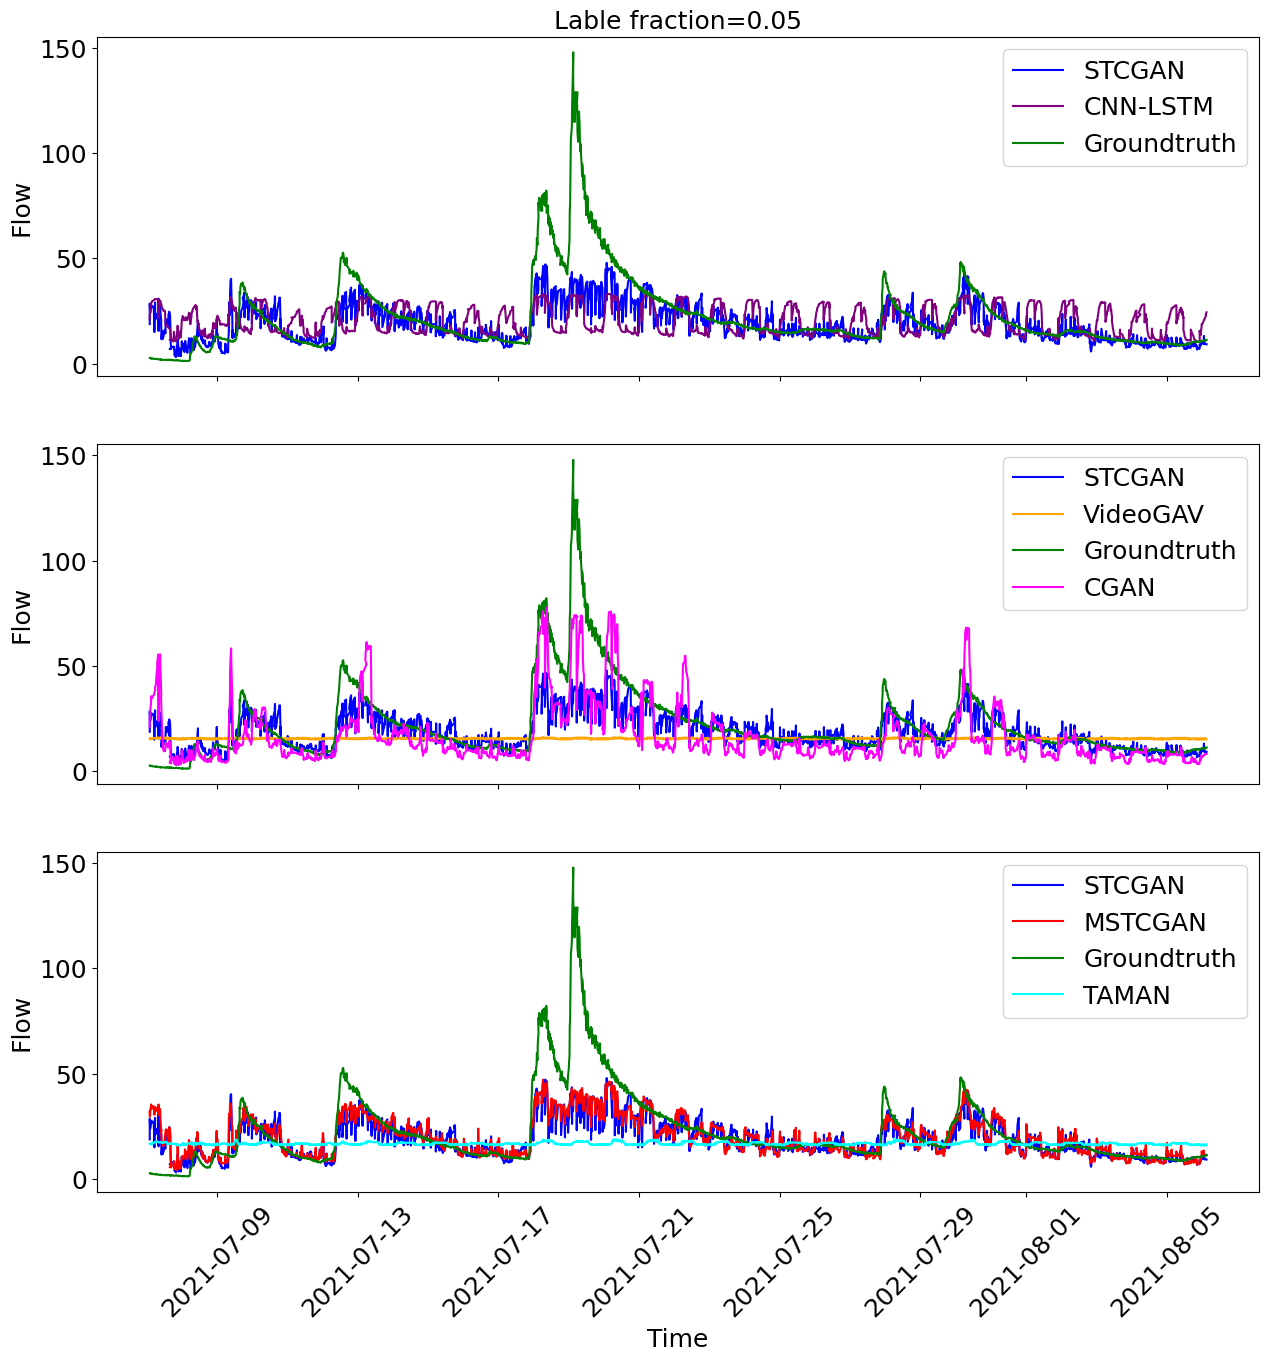

In [101]:
import matplotlib.pyplot as plt
# time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
# time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
# time_X_list=np.sort(time_X_list)
# time_Y_list=np.sort(time_Y_list)
end=2700
# idx = np.asarray(time_X_list[int(len(time_X_list)*.85)]>=time_X_list).nonzero()
fig, axs = plt.subplots(3, sharex=True, sharey=True,figsize=(15, 15))
axs[0].plot(time_X_list1[:end],prd1[:end], label="STCGAN",color='blue')
axs[0].plot(time_X_list1[:end],prd_cnn1[:end], label="CNN-LSTM",color='purple')
axs[0].plot(time_X_list1[:end],labels_X_list1[:end], label="Groundtruth",color='green')
axs[1].plot(time_X_list1[:end],prd1[:end], label="STCGAN",color='blue')
axs[1].plot(time_X_list1[:end],prd_v2v1[:end], label="VideoGAV",color='orange')
axs[1].plot(time_X_list1[:end],labels_X_list1[:end], label="Groundtruth",color='green')
axs[1].plot(time_X_list1[:end],prd_cycle1[:end], label="CGAN",color='magenta')
axs[2].plot(time_X_list1[:end],prd1[:end], label="STCGAN",color='blue')
axs[2].plot(time_X_list1[:end],prd_ms1[:end], label="MSTCGAN",color='red')
axs[2].plot(time_X_list1[:end],labels_X_list1[:end], label="Groundtruth",color='green')
axs[2].plot(time_X_list1[:end],prd_taman1[:end], label="TAMAN",color='cyan')
axs[0].legend(fontsize='18')
axs[1].legend(fontsize='18')
axs[2].legend(fontsize='18')
axs[0].set_title('Lable fraction=0.05',fontsize='18')
plt.tick_params(axis='x', rotation=45,labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[2].tick_params(axis='y', labelsize=18)
axs[0].set_ylabel("Flow",fontsize='18')
axs[1].set_ylabel("Flow",fontsize='18')
axs[2].set_ylabel("Flow",fontsize='18')
plt.xlabel("Time",fontsize='18')

In [455]:
# one2many

from matplotlib import axis
def loadcheckpoint(opts, G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y):
    """Save generators G_YtoX, G_XtoY and discriminators D_X, D_Y."""

    G_XtoY_path = os.path.join(
        opts.checkpoint_dir, 'G_XtoY-best.pkl'
    )
    G_YtoX_path = os.path.join(
        opts.checkpoint_dir, 'G_YtoX-best.pkl'
    )
    D_X_path = os.path.join(opts.checkpoint_dir, 'D_X-best.pkl')
    D_Y_path = os.path.join(opts.checkpoint_dir, 'D_Y-best.pkl')
    Cls_X_path = os.path.join(opts.checkpoint_dir, 'Cls_X-best.pkl')
    Cls_Y_path = os.path.join(opts.checkpoint_dir, 'Cls_Y-best.pkl')

    G_XtoY.load_state_dict(torch.load(G_XtoY_path, map_location="cuda"))
    G_YtoX.load_state_dict(torch.load(G_YtoX_path, map_location="cuda"))
    D_X.load_state_dict(torch.load(D_X_path, map_location="cuda"))
    D_Y.load_state_dict(torch.load(D_Y_path, map_location="cuda"))
    Cls_X.load_state_dict(torch.load(Cls_X_path, map_location="cuda"))
    Cls_Y.load_state_dict(torch.load(Cls_Y_path, map_location="cuda"))
    return G_XtoY, G_YtoX, D_X, D_Y, Cls_X, Cls_Y

def save_samples_test(iteration, fixed_Y, c_Y, id_Y, label_Y, fixed_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y, tp="all")
    save_images(Y, c_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X, tp="all")

def save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_Y, label_Y, fixed_X, c_fixed_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts):
    fake_X = G_YtoX(fixed_Y, c_X)
    fake_Y = G_XtoY(fixed_X, c_Y)
    pred_Y = Cls_Y(fake_Y, c_Y)
    pred_X = Cls_X(fake_X, c_X)

    X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), X_normalizer.inverse_transform(utils.to_data(label_X)), X_normalizer.inverse_transform(utils.to_data(pred_X))
    Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), Y_normalizer.inverse_transform(utils.to_data(label_Y)), Y_normalizer.inverse_transform(utils.to_data(pred_Y))
    # X, fake_X, label_X, pred_X = utils.to_data(fixed_X), utils.to_data(fake_X), np.exp(utils.to_data(label_X))-1, np.exp(utils.to_data(pred_X)-1)
    # Y, fake_Y, label_Y, pred_Y = utils.to_data(fixed_Y), utils.to_data(fake_Y), np.exp(utils.to_data(label_Y))-1, np.exp(utils.to_data(pred_Y)-1)
    # dates_Y=np.datetime_as_string(utils.to_data(c_Y), timezone='UTC')
    # dates_X=np.datetime_as_string(utils.to_data(c_X), timezone='UTC')
    save_images(X, c_fixed_X, label_X, fake_Y, c_Y, pred_Y, opts, iteration,"X_Y", id_X, id_Y)
    save_images(Y, c_fixed_Y, label_Y, fake_X, c_X, pred_X, opts, iteration,"Y_X", id_Y, id_X)

def test_loop(X,Y,dataloader_X, dataloader_Y, X_normalizer, Y_normalizer, opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """

    # # Create generators and discriminators
    cx = EasyDict() # Main config dict.
    cond_desc(cx, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_X))
    dequant_X=Dequantizer(cx.cond_args, X.timestamps)
    cy = EasyDict() # Main config dict.
    cond_desc(cy, opts, cond_type=opts.cond, noise=opts.noise, frames=len(dataloader_Y))
    dequant_Y=Dequantizer(cy.cond_args, Y.timestamps)

    i=0
    dct={}
    wei_total=0
    for subdir in os.listdir(root+opts.output):
        if f"_{opts.mask_frac}_0_1_5" in subdir:
            for f in os.listdir(root+opts.output+subdir):
                if "cycle_time" not in f:
                    continue
                opts.checkpoint_dir=root+opts.output+subdir+"/"+f+"/checkpoints_cyclegan"

                loss=torch.load(os.path.join(opts.checkpoint_dir, "loss_best.pth"))
                dct[f'wei_{i}']=1/(loss['Cls_X_loss']+loss['Cls_X2Y_loss'])
#                 dct[f'wei_{i}']=1
                wei_total+=dct[f'wei_{i}']
                dct[f'G_XtoY_{i}'], dct[f'G_YtoX_{i}'], dct[f'D_X_{i}'], dct[f'D_Y_{i}'], dct[f'Cls_X_{i}'], dct[f'Cls_Y_{i}'] = create_model(opts,cx,cy)
                dct[f'G_XtoY_{i}'], dct[f'G_YtoX_{i}'], dct[f'D_X_{i}'], dct[f'D_Y_{i}'], dct[f'Cls_X_{i}'], dct[f'Cls_Y_{i}'] = loadcheckpoint(opts,dct[f'G_XtoY_{i}'], dct[f'G_YtoX_{i}'], dct[f'D_X_{i}'], dct[f'D_Y_{i}'], dct[f'Cls_X_{i}'], dct[f'Cls_Y_{i}'])
                dct[f'G_XtoY_{i}'].eval(), dct[f'G_YtoX_{i}'].eval(), dct[f'D_X_{i}'].eval(), dct[f'D_Y_{i}'].eval(), dct[f'Cls_X_{i}'].eval(), dct[f'Cls_Y_{i}'].eval()
                i+=1
    nums=i-1

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)

    # Get some fixed data from domains X and Y for sampling.
    # These are images that are held constant throughout training,
    # that allow us to inspect the model's performance.
    fixed_X, c_fixed_X, label_fixed_X, id_fixed_X = next(iter_X)
    fixed_Y, c_fixed_Y, label_fixed_Y, id_fixed_Y = next(iter_Y)

    fixed_X = fixed_X.squeeze(0)
    c_fixed_X = c_fixed_X.squeeze(0)
    label_fixed_X = label_fixed_X.squeeze(0)
#     label_fixed_X = label_fixed_X.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_X = label_fixed_X.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_X = label_fixed_X.reshape(label_fixed_X.shape[0] * label_fixed_X.shape[1], label_fixed_X.shape[2])  # (seq_len * N, 1)

    fixed_Y = fixed_Y.squeeze(0)
    c_fixed_Y = c_fixed_Y.squeeze(0)
    label_fixed_Y = label_fixed_Y.squeeze(0)
#     label_fixed_Y = label_fixed_Y.reshape(opts.batch_size, opts.len_seq, 1)
#     label_fixed_Y = label_fixed_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#     label_fixed_Y = label_fixed_Y.reshape(label_fixed_Y.shape[0] * label_fixed_Y.shape[1], label_fixed_Y.shape[2])  # (seq_len * N, 1)

    fixed_c_X = dequant_X(c_fixed_X)
    fixed_c_Y = dequant_Y(c_fixed_Y)
    fixed_X = utils.to_var(fixed_X)
    fixed_Y = utils.to_var(fixed_Y)
    label_fixed_X = utils.to_var(label_fixed_X)
    label_fixed_Y = utils.to_var(label_fixed_Y)
    c_fixed_X = utils.to_var(c_fixed_X)
    c_fixed_Y = utils.to_var(c_fixed_Y)

    iter_per_epoch_X, iter_per_epoch_Y = len(iter_X), len(iter_Y)
    iter_per_epoch=min(iter_per_epoch_X, iter_per_epoch_Y)
    d_real_loss_hist = D_Y_loss_hist = D_X_loss_hist = d_fake_loss_hist = g_loss_hist=0
    Cls_Y_loss_hist = Cls_X_loss_hist=Cls_Y2X_loss_hist = Cls_X2Y_loss_hist=0
    labels_X_list=np.array([])
    labels_Y_list=np.array([])
    preds_X_list=np.array([])
    preds_Y_list=np.array([])
    preds_X2Y_list=np.array([])
    preds_Y2X_list=np.array([])
    time_X_list=np.array([])
    time_Y_list=np.array([])

    with torch.no_grad():
        for iteration in range(1, min(iter_per_epoch_X, iter_per_epoch_Y)):
            # Reset data_iter for each epoch
            if iteration % iter_per_epoch_X == 0:
                iter_X = iter(dataloader_X)
            if iteration % iter_per_epoch_Y == 0:
                iter_Y = iter(dataloader_Y)

            images_X, c_X, label_X, id_X = next(iter_X)
            images_Y, c_Y, label_Y, id_Y = next(iter_Y)

            images_X = images_X.squeeze(0)
            c_X = c_X.squeeze(0)
            label_X = label_X.squeeze(0)
#             label_X = label_X.reshape(opts.batch_size, opts.len_seq, 1)
#             label_X = label_X.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_X = label_X.reshape(label_X.shape[0] * label_X.shape[1], label_X.shape[2])  # (seq_len * N, 1)

            images_Y = images_Y.squeeze(0)
            c_Y = c_Y.squeeze(0)
            label_Y = label_Y.squeeze(0)
#             label_Y = label_Y.reshape(opts.batch_size, opts.len_seq, 1)
#             label_Y = label_Y.permute(1, 0, 2)  # (seq_len, N, 1)
#             label_Y = label_Y.reshape(label_Y.shape[0] * label_Y.shape[1], label_Y.shape[2])  # (seq_len * N, 1)

            c_X = dequant_X(c_X)
            c_Y = dequant_Y(c_Y)
            images_X = utils.to_var(images_X)
            label_X = utils.to_var(label_X)
            images_Y = utils.to_var(images_Y)
            label_Y = utils.to_var(label_Y)
            c_X = utils.to_var(c_X)
            c_Y = utils.to_var(c_Y)


            pred_fake_Y_avg=0
            pred_fake_X_avg=0
            pred_real_Y_avg=0
            pred_real_X_avg=0
#             wei_total=0
            i=0

            for subdir in os.listdir(root+opts.output):
                if f"_{opts.mask_frac}_0_1_5" in subdir:
                    for f in os.listdir(root+opts.output+subdir):
                        if "cycle_time" not in f:
                            continue

            #             # 1. Compute the discriminator losses on real images
            #             D_X_loss = torch.mean((D_X(images_X, c_X)-1)**2)
            #             D_Y_loss = torch.mean((D_Y(images_Y, c_Y)-1)**2)

            #             d_real_loss = D_X_loss + D_Y_loss

                        # 2. Generate domain-X-like images based on real images in domain Y
                        fake_X = dct[f'G_YtoX_{i}'](images_Y, c_X)

                        # 3. Compute the loss for D_X
                        D_fake_X_loss = torch.mean(dct[f'D_X_{i}'](fake_X.detach(), c_X)**2)

                        # 4. Generate domain-Y-like images based on real images in domain X
                        fake_Y=dct[f'G_XtoY_{i}'](images_X, c_Y)

        #                 # 5. Compute the loss for D_Y
        #                 D_fake_Y_loss = torch.mean(f'D_Y_{i}'(fake_Y.detach(), c_Y)**2)

        #                 d_fake_loss = D_fake_X_loss + D_fake_Y_loss
        #                 d_total_loss = d_real_loss + d_fake_loss

                        # Class loss
                        pred_fake_Y = dct[f'Cls_X_{i}'](fake_Y.detach(), c_Y)
                        Cls_X2Y_loss = torch.mean((pred_fake_Y-label_X)**2)
                        pred_real_X = dct[f'Cls_X_{i}'](images_X, c_X)

                        pred_real_X_avg+=pred_real_X*(wei_total-dct[f'wei_{i}'])
#                         pred_real_X_avg+=pred_real_X*dct[f'wei_{i}']

                        lbl_X=utils.to_var(torch.from_numpy(X_normalizer.inverse_transform(utils.to_data(label_X))))
                        pred_real_X=utils.to_var(torch.from_numpy(X_normalizer.inverse_transform(utils.to_data(pred_real_X))))

#                         Cls_X_loss = torch.sqrt(criterion_cls(pred_real_X,lbl_X))
                        Cls_X_loss = torch.mean((pred_real_X-lbl_X)**2)

                        pred_fake_X = dct[f'Cls_Y_{i}'](fake_X.detach(), c_X)
                        Cls_Y2X_loss = torch.mean((pred_fake_X-label_Y)**2)
                        pred_real_Y = dct[f'Cls_Y_{i}'](images_Y, c_Y)

                        pred_real_Y_avg+=pred_real_Y*(wei_total-dct[f'wei_{i}'])
#                         pred_real_Y_avg+=pred_real_Y*dct[f'wei_{i}']

                        lbl_Y=utils.to_var(torch.from_numpy(Y_normalizer.inverse_transform(utils.to_data(label_Y))))
                        pred_real_Y=utils.to_var(torch.from_numpy(Y_normalizer.inverse_transform(utils.to_data(pred_real_Y))))

                        Cls_Y_loss = torch.sqrt(criterion_cls(pred_real_Y,lbl_Y))
#                         Cls_Y_loss = torch.mean((pred_real_Y-label_Y)**2)

                        Cls_total_loss=(Cls_X2Y_loss + Cls_Y_loss + Cls_Y2X_loss + Cls_X_loss) * opts.lambda_cls

                        pred_fake_Y_avg+=pred_fake_Y*(wei_total-dct[f'wei_{i}'])
                        pred_fake_X_avg+=pred_fake_X*(wei_total-dct[f'wei_{i}'])
#                         pred_fake_Y_avg+=pred_fake_Y*dct[f'wei_{i}']
#                         pred_fake_X_avg+=pred_fake_X*dct[f'wei_{i}']

                        # pred_fake_Y_avg=pred_fake_Y_avg+pred_fake_Y
                        # pred_fake_X_avg=pred_fake_X_avg+pred_fake_X
                        # pred_real_Y_avg=pred_real_Y_avg+pred_real_Y
                        # pred_real_X_avg=pred_real_X_avg+pred_real_X
                        i+=1

            pred_fake_Y_avg/=nums*wei_total
            pred_fake_X_avg/=nums*wei_total
            pred_real_Y_avg/=nums*wei_total
            pred_real_X_avg/=nums*wei_total
#             pred_fake_Y_avg=pred_fake_Y_avg/i
#             pred_fake_X_avg=pred_fake_X_avg/i
#             pred_real_Y_avg=pred_real_Y_avg/i
#             pred_real_X_avg=pred_real_X_avg/i

            preds_X2Y_list=np.append(preds_X2Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_fake_Y_avg)).squeeze())
            preds_Y2X_list=np.append(preds_Y2X_list, X_normalizer.inverse_transform(utils.to_data(pred_fake_X_avg)).squeeze())
            preds_X_list=np.append(preds_X_list, X_normalizer.inverse_transform(utils.to_data(pred_real_X_avg)).squeeze())
            preds_Y_list=np.append(preds_Y_list, Y_normalizer.inverse_transform(utils.to_data(pred_real_Y_avg)).squeeze())
            labels_X_list=np.append(labels_X_list, X_normalizer.inverse_transform(utils.to_data(label_X)).squeeze())
            labels_Y_list=np.append(labels_Y_list, Y_normalizer.inverse_transform(utils.to_data(label_Y)).squeeze())
            # preds_X2Y_list=np.append(preds_X2Y_list, np.exp(utils.to_data(pred_fake_Y))-1)
            # preds_Y2X_list=np.append(preds_Y2X_list, np.exp(utils.to_data(pred_fake_X))-1)
            # preds_X_list=np.append(preds_X_list, np.exp(utils.to_data(pred_real_X))-1)
            # preds_Y_list=np.append(preds_Y_list, np.exp(utils.to_data(pred_real_Y))-1)
            # labels_X_list=np.append(labels_X_list, np.exp(utils.to_data(label_X))-1)
            # labels_Y_list=np.append(labels_Y_list, np.exp(utils.to_data(label_Y))-1)
            time_X_list=np.append(time_X_list, X.timetransformer.inverse_transform(utils.to_data(c_X)).squeeze())
            time_Y_list=np.append(time_Y_list, Y.timetransformer.inverse_transform(utils.to_data(c_Y)).squeeze())


            Cls_Y_loss_hist += Cls_Y_loss
            Cls_X_loss_hist += Cls_X_loss
            Cls_Y2X_loss_hist += Cls_Y2X_loss
            Cls_X2Y_loss_hist += Cls_X2Y_loss
            ## Save the generated samples
            #save_samples_test(iteration, images_Y, c_Y, id_Y, label_Y, images_X, c_X, id_X, label_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, X_normalizer, Y_normalizer, opts)
            #save_samples_fixed(iteration, fixed_Y, c_fixed_Y, id_fixed_Y, label_fixed_Y, fixed_X, c_fixed_X, id_fixed_X, label_fixed_X, G_YtoX, G_XtoY, Cls_X, Cls_Y, c_Y, c_X, X_normalizer, Y_normalizer, opts)

    print(
        'Iteration [{}] |'
        'Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}| Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f}'.format(
            iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch

        ))

    print("Error_X", np.mean(np.abs(labels_X_list-preds_X_list)))
    NSE=1-np.sum((labels_X_list-preds_X_list)**2)/np.sum((labels_X_list-np.mean(labels_X_list))**2)
    print('NSE',NSE)

    loss_all = 'Iteration [{}] | Cls_Y_loss: {:6.4f} | Cls_X_loss: {:6.4f}| Cls_Y2X_loss: {:6.4f} | Cls_X2Y_loss: {:6.4f}'.format(
            iter_per_epoch,
            Cls_Y_loss_hist.item()/iter_per_epoch, Cls_X_loss_hist.item()/iter_per_epoch,
            Cls_Y2X_loss_hist.item()/iter_per_epoch, Cls_X2Y_loss_hist.item()/iter_per_epoch)


    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

def main(opts):
    """Loads the data and starts the training loop."""
    cur_path = root_data
#     for fol_X in ["West Brook Lower_01171090"]:
    for fol_X in ["West Brook Reservoir_01171020"]:
        for fol_Y in [opts.Y]:
#         for fol_Y in ["Avery Brook_River Right_01171000"]:
        # for fol_Y in ["Avery Brook_River Left_01171000"]:
#         for fol_Y in ["Obear Brook Lower_01171070"]:
            X=ImageNetVidDataset(path= cur_path, fol=fol_X, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)
            Y=ImageNetVidDataset(path= cur_path, fol=fol_Y, phase="test", len_seq=opts.batch_size*opts.len_seq, transform=transform)

            # # Create  dataloaders for images from the two domains X and Y
            dataloader_X = torch.utils.data.DataLoader(X, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            dataloader_Y = torch.utils.data.DataLoader(Y, batch_size=1, shuffle=False, num_workers=0, drop_last=True)
            # dataset = ImageNetVidDataset(path= cur_path, fol_A=fol_X, fol_B=fol_Y, phase="train", len_seq=len_seq, transform=transform)
            # dataset_val = ImageNetVidDataset(path= cur_path, fol_A=fol_A, fol_B=fol_B, phase="val", len_seq=len_seq, transform=transform)
            # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

            # Create checkpoint and sample directories
            utils.create_dir(opts.sample_dir)

            # Start training
            labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = test_loop(X, Y ,dataloader_X, dataloader_Y, X.normalizer, Y.normalizer, opts)
            # training_loop(dataloader, opts)
            time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
            time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
    return labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all

if __name__ == '__main__':

    opts.sample_dir = os.path.join(
        root, 'output_one2many/'
        '%s_%s_%g_%g_%g_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac, opts.lambda_cls, opts.lambda_aug, opts.lambda_cycle_cls)
    )
    opts.sample_dir += '%s_%s_%s_%s_%g_%s' % (
        opts.data_preprocess, opts.norm, opts.disc, opts.gen, opts.lambda_cycle, opts.init_type
    )
    if opts.use_cycle_consistency_loss:
        opts.sample_dir += '_cycle'
    if opts.use_diffaug:
        opts.sample_dir += '_diffaug'

    opts.sample_dir = os.path.join(
        opts.sample_dir, 'test/'
    )

    if os.path.exists(opts.sample_dir):
        cmd = 'rm %s/*' % opts.sample_dir
        os.system(cmd)

    batch_size=opts.batch_size
#     len_seq=opts.len_seq

    labels_X_list, labels_Y_list, preds_X_list, preds_Y_list, preds_X2Y_list, preds_Y2X_list, time_X_list, time_Y_list, loss_all = main(opts)


rm: cannot remove '/users/esmaeil/spatial_temporal/stream_img/CGAN/output_one2many/West': No such file or directory
rm: cannot remove 'Brook': No such file or directory
rm: cannot remove 'Reservoir_Avery': No such file or directory
rm: cannot remove 'Brook_River': No such file or directory
rm: cannot remove 'Left_01171000_0_1_1_5/basic_instance_patch_cycle_time_5_naive_cycle_diffaug/test//*': No such file or directory


                 G_XtoY                
---------------------------------------
CycleTStyleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (resnet_block1): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_block2): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, af

                 G_XtoY                
---------------------------------------
CycleTStyleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (resnet_block1): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_block2): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, af

                 G_XtoY                
---------------------------------------
CycleTStyleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (resnet_block1): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_block2): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, af

                 G_XtoY                
---------------------------------------
CycleTStyleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (resnet_block1): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_block2): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, af

                 G_XtoY                
---------------------------------------
CycleTStyleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (resnet_block1): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (resnet_block2): ResnetBlock(
    (conv_layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, af

Iteration [162] |Cls_Y_loss: 10.8293 | Cls_X_loss: 118.6862| Cls_Y2X_loss: 0.9284 | Cls_X2Y_loss: 0.4458
Error_X 5.068514533072525
NSE 0.6917167425311079


In [456]:
opts.sample_dir = os.path.join(
    root, 'plot/'
    '%s_%s_%g/' % (opts.X.split('/')[0], opts.Y.split('/')[0], opts.mask_frac)
)
utils.create_dir(opts.sample_dir)
opts.sample_dir += '%s_ms_' % (
    opts.gen
)

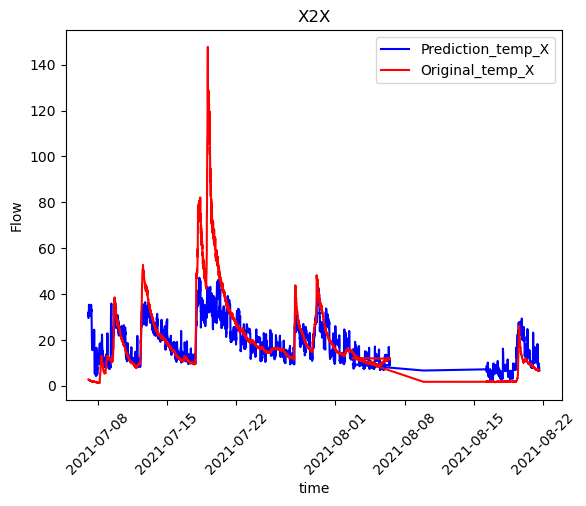

In [292]:
import matplotlib.pyplot as plt
# time_X_list=[np.datetime64(int(cur), "s") for cur in time_X_list]
# time_Y_list=[np.datetime64(int(cur), "s") for cur in time_Y_list]
time_X_list1=np.sort(time_X_list1)
# time_Y_list=np.sort(time_Y_list)

fig=plt.figure()
plt.plot(time_X_list,preds_X_list, label="Prediction_temp_X",color='blue')
plt.plot(time_X_list,labels_X_list, label="Original_temp_X",color='red')
plt.tick_params(axis='x', rotation=45,labelsize=10)
plt.ylabel("Flow")
plt.xlabel("time")
plt.title('X2X')
plt.legend()

In [457]:
np.save(opts.sample_dir + 'labels_X.npy',labels_X_list)
np.save(opts.sample_dir + 'labels_Y.npy',labels_Y_list)
np.save(opts.sample_dir + 'preds_X2Y.npy',preds_X2Y_list)
np.save(opts.sample_dir + 'preds_Y2X.npy',preds_Y2X_list)
np.save(opts.sample_dir + 'preds_X.npy',preds_X_list)
np.save(opts.sample_dir + 'preds_Y.npy',preds_Y_list)
np.save(opts.sample_dir + 'time_X.npy',time_X_list)
np.save(opts.sample_dir + 'time_Y.npy',time_Y_list)
np.save(opts.sample_dir + 'loss_all.npy',loss_all)

In [ ]:
# lsof -i :<port_number> | awk 'NR!=1 {print $2}' | xargs -r kill
# ps -aux | grep <port_number>
%load_ext tensorboard
%tensorboard --logdir root+opts.output+'/_5basic_instance_patch_cycle_time_me_naive_cycle_diffaug/' --port=6010